In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:

%%writefile diffusion_utils_equal_snr.py
# diffusion_utils_equal_snr.ipynb
# Full utilities for DDPM / EqualSNR / FlippedSNR diffusion in Fourier space.
# GPU-first (all tensors default to CUDA when available).

import math
import os
import random
from dataclasses import dataclass
from typing import Dict, Optional, Tuple, Literal, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_device() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_all(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

#Fourier transform utils for real-valued images: rfft2 and irfft2 + complex variance
def rfft2(x: torch.Tensor) -> torch.Tensor:
    # x: (B,C,H,W) real
    return torch.fft.rfft2(x, dim=(-2, -1), norm="ortho")

def irfft2(y: torch.Tensor, h: int, w: int) -> torch.Tensor:
    # y: (B,C,H,W//2+1) complex
    return torch.fft.irfft2(y, s=(h, w), dim=(-2, -1), norm="ortho")

def complex_var(y: torch.Tensor, dim: int = 0, eps: float = 1e-12) -> torch.Tensor:
    # Var(Re)+Var(Im) along dim
    re = y.real
    im = y.imag
    return re.var(dim=dim, unbiased=False) + im.var(dim=dim, unbiased=False) + eps

#Schedules
def make_beta_schedule(T: int, beta_start: float = 1e-4, beta_end: float = 2e-2, device=None) -> torch.Tensor:
    # Linear beta schedule
    device = device or get_device()
    return torch.linspace(beta_start, beta_end, T, device=device)

def alphas_from_betas(betas: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # betas shape (T,)
    alphas = 1.0 - betas
    alpha_bar = torch.cumprod(alphas, dim=0)
    return alphas, alpha_bar

def snr_from_alpha_bar(alpha_bar: torch.Tensor, C: Optional[torch.Tensor] = None, Sigma_diag: Optional[torch.Tensor] = None) -> torch.Tensor:
    # s_t(i) = alpha_bar_t * C_i / ((1-alpha_bar_t) * Sigma_ii)
    # If C is None, assume C_i = 1. If Sigma_diag is None assume Sigma_ii=1 (DDPM).
    T = alpha_bar.shape[0]
    if C is None:
        # scalar 1
        C = torch.ones(1, device=alpha_bar.device)
    if Sigma_diag is None:
        Sigma_diag = torch.ones_like(C)
    # broadcast: (T,1,...) then to match C
    ab = alpha_bar.view(T, *([1] * C.ndim))
    return (ab * C) / ((1.0 - ab) * Sigma_diag)

def calibrate_equal_snr_alpha_bar(alpha_bar_ddpm: torch.Tensor, C_diag: torch.Tensor) -> torch.Tensor:
    """
    choose alpha_bar_eq so that average SNR across frequencies matches DDPM at each t:
      alpha_eq/(1-alpha_eq) = alpha_ddpm/(1-alpha_ddpm) *  (1/d) sum_i C_i
    => alpha_eq = alpha_ddpm * meanC / ((1-alpha_ddpm) + alpha_ddpm*meanC)
    """
    meanC = C_diag.mean()
    ab = alpha_bar_ddpm
    ab_eq = (ab * meanC) / ((1.0 - ab) + ab * meanC)
    return ab_eq.clamp(1e-8, 1.0 - 1e-8)

# Frequency covariance and Sigma construction
def estimate_C_diag_rfft2(
    loader,
    device: torch.device,
    n_batches: int = 200,
    clamp_min: float = 1e-8,
) -> torch.Tensor:
    """
    Estimate C_i = Var[(y0)_i] in Fourier domain using rFFT2.
    Returns C_diag with shape (C,H,W//2+1) for Equal/FlippedSNR.
    """
    # Run second moment and mean for complex variance
    sum_re = None
    sum_im = None
    sum_re2 = None
    sum_im2 = None
    n = 0

    for bi, batch in enumerate(loader):
        if bi >= n_batches:
            break
        x0 = batch[0] if isinstance(batch, (list, tuple)) else batch
        x0 = x0.to(device, non_blocking=True).float()
        y0 = rfft2(x0)  # (B,C,H,Wf)
        re = y0.real
        im = y0.imag
        if sum_re is None:
            sum_re = re.sum(dim=0)
            sum_im = im.sum(dim=0)
            sum_re2 = (re ** 2).sum(dim=0)
            sum_im2 = (im ** 2).sum(dim=0)
        else:
            sum_re += re.sum(dim=0)
            sum_im += im.sum(dim=0)
            sum_re2 += (re ** 2).sum(dim=0)
            sum_im2 += (im ** 2).sum(dim=0)
        n += re.shape[0]
    mean_re = sum_re / max(n, 1)
    mean_im = sum_im / max(n, 1)
    var_re = (sum_re2 / max(n, 1)) - mean_re ** 2
    var_im = (sum_im2 / max(n, 1)) - mean_im ** 2
    C_diag = (var_re + var_im).clamp_min(clamp_min)
    return C_diag

def make_sigma_diag(
    scheme: Literal["ddpm", "equal_snr", "flipped_snr"],
    C_diag: torch.Tensor,
) -> torch.Tensor:
    """
    Return Sigma_ii for forward noise eps ~ CN(0, Sigma) (Diangonal)
    - DDPM: Sigma=I => Sigma_diag = 1
    - EqualSNR: Sigma_diag = C_diag (variance-preserving c=1)
    - FlippedSNR: Sigma_diag = C_i / C_flipped(i)
    """
    if scheme == "ddpm":
        return torch.ones_like(C_diag)
    if scheme == "equal_snr":
        return C_diag.clone()
    if scheme == "flipped_snr":
        # Radial flip
        C, H, Wf = C_diag.shape
        device = C_diag.device
        yy = torch.arange(H, device=device)
        xx = torch.arange(Wf, device=device)
        # frequency indices for rfft
        u = torch.minimum(yy, H - yy).float().view(H, 1)  # (H,1)
        v = xx.float().view(1, Wf)  # (1,Wf)
        r = torch.sqrt(u ** 2 + v ** 2)  # (H,Wf)
        r_max = r.max()
        r_flip = (r_max - r).clamp_min(0.0)

        # Create bins over r and average C over those bins for each channel.
        nbins = int(max(H, Wf))
        bins = torch.linspace(0.0, r_max, nbins, device=device)
        # assign bin indices
        idx = torch.bucketize(r.flatten(), bins) - 1
        idx = idx.clamp(0, nbins - 1).view(H, Wf)
        idx_flip = torch.bucketize(r_flip.flatten(), bins) - 1
        idx_flip = idx_flip.clamp(0, nbins - 1).view(H, Wf)

        # average C per bin per channel
        Cbin = torch.zeros(C, nbins, device=device)
        counts = torch.zeros(nbins, device=device)
        for b in range(nbins):
            mask = (idx == b)
            counts[b] = mask.sum().float().clamp_min(1.0)
            Cbin[:, b] = (C_diag[:, mask].sum(dim=1)) / counts[b]

        # gather flipped C for each position
        C_flip = Cbin[:, idx_flip]  # (C,H,Wf)
        Sigma = (C_diag / C_flip.clamp_min(1e-8)).clamp_min(1e-8)
        return Sigma

    raise ValueError(f"Unknown scheme: {scheme}")

#Forward process and sampling
@dataclass
class FourierDiffusionConfig:
    T: int = 1000
    beta_start: float = 1e-4
    beta_end: float = 2e-2
    schedule: Literal["ddpm", "equal_snr", "flipped_snr"] = "ddpm"
    # If equal_snr or flipped_snr, use calibrated alpha_bar unless disabled:
    calibrate_alpha_bar: bool = True

class FourierForwardProcess:
    def __init__(self, cfg: FourierDiffusionConfig, C_diag: Optional[torch.Tensor], device: torch.device):
        self.cfg = cfg
        self.device = device
        betas = make_beta_schedule(cfg.T, cfg.beta_start, cfg.beta_end, device=device)
        _, alpha_bar_ddpm = alphas_from_betas(betas)

        if cfg.schedule == "ddpm" or C_diag is None:
            self.alpha_bar = alpha_bar_ddpm
            self.C_diag = None
            self.Sigma_diag = None
        else:
            self.C_diag = C_diag.to(device)
            self.Sigma_diag = make_sigma_diag(cfg.schedule, self.C_diag)
            if cfg.calibrate_alpha_bar and cfg.schedule == "equal_snr":
                self.alpha_bar = calibrate_equal_snr_alpha_bar(alpha_bar_ddpm, self.C_diag)  # App. A.3 fileciteturn1file0L14-L78
            else:
                self.alpha_bar = alpha_bar_ddpm

        self.alpha_bar = self.alpha_bar.clamp(1e-8, 1.0 - 1e-8)

    def sample_t(self, batch: int) -> torch.Tensor:
        # integer timesteps in [1..T]
        return torch.randint(1, self.cfg.T + 1, (batch,), device=self.device)

    def alpha_bar_t(self, t: torch.Tensor) -> torch.Tensor:
        # t in [1..T], returns alpha_bar[t-1]
        return self.alpha_bar[t - 1]

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, noise: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """
        Return xt (pixel space) and aux dict with y0, yt, eps_y used.
        Implement Fourier-space forward:
          y_t = sqrt(ab)*y0 + sqrt(1-ab)*eps_Sigma
        where eps_Sigma ~ CN(0, Sigma) via eps * sqrt(Sigma_diag).
        """
        B, C, H, W = x0.shape
        ab = self.alpha_bar_t(t).view(B, 1, 1, 1)

        if self.cfg.schedule == "ddpm" or self.C_diag is None:
            if noise is None:
                noise = torch.randn_like(x0)
            xt = torch.sqrt(ab) * x0 + torch.sqrt(1.0 - ab) * noise
            return xt, {"x0": x0, "noise": noise, "alpha_bar": ab.squeeze()}

        # Fourier path
        y0 = rfft2(x0)  # (B,C,H,Wf)
        Wf = y0.shape[-1]

        if noise is None:
            # complex standard normal in rfft domain: N(0,1) for real and imaginary
            eps = (torch.randn((B, C, H, Wf), device=self.device) +
                   1j * torch.randn((B, C, H, Wf), device=self.device)) / math.sqrt(2.0)
        else:
            eps = noise  # user supplied complex eps in rfft shape

        sigma_sqrt = torch.sqrt(self.Sigma_diag).unsqueeze(0)
        eps_sigma = eps * sigma_sqrt

        ab_y = self.alpha_bar_t(t).view(B, 1, 1, 1)
        yt = torch.sqrt(ab_y) * y0 + torch.sqrt(1.0 - ab_y) * eps_sigma
        xt = irfft2(yt, H, W)
        return xt, {"y0": y0, "yt": yt, "eps_sigma": eps_sigma, "alpha_bar": ab_y.squeeze()}

# UNet for iamges / MLP for 2d toy example
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t in [1..T], map to [0,1]
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device).float() / (half - 1))
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1))
        return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, t_dim: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb = nn.Linear(t_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.gn2 = nn.GroupNorm(8, out_ch)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(x)
        h = self.gn1(h)
        h = F.silu(h)
        h = h + self.emb(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(h)
        h = self.gn2(h)
        h = F.silu(h)
        return h + self.skip(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch: int, base: int = 64, t_dim: int = 128):
        super().__init__()
        self.t_emb = nn.Sequential(
            SinusoidalTimeEmbedding(t_dim),
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim),
        )
        self.d1 = ResBlock(in_ch, base, t_dim)
        self.d2 = ResBlock(base, base*2, t_dim)
        self.d3 = ResBlock(base*2, base*4, t_dim)
        self.pool = nn.AvgPool2d(2)
        self.u2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.u3 = nn.Upsample(scale_factor=2, mode="nearest")
        self.m1 = ResBlock(base*4, base*4, t_dim)
        self.u_block2 = ResBlock(base*4 + base*2, base*2, t_dim)
        self.u_block1 = ResBlock(base*2 + base, base, t_dim)
        self.out = nn.Conv2d(base, in_ch, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        te = self.t_emb(t)
        h1 = self.d1(x, te)
        h2 = self.d2(self.pool(h1), te)
        h3 = self.d3(self.pool(h2), te)
        h = self.m1(h3, te)
        h = self.u3(h)
        h = self.u_block2(torch.cat([h, h2], dim=1), te)
        h = self.u2(h)
        h = self.u_block1(torch.cat([h, h1], dim=1), te)
        return self.out(h)

class ToyMLP(nn.Module):
    def __init__(self, dim: int = 2, hidden: int = 256, t_dim: int = 128):
        super().__init__()
        self.t_emb = nn.Sequential(
            SinusoidalTimeEmbedding(t_dim),
            nn.Linear(t_dim, t_dim),
            nn.SiLU(),
            nn.Linear(t_dim, t_dim),
        )
        self.net = nn.Sequential(
            nn.Linear(dim + t_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        te = self.t_emb(t)
        return self.net(torch.cat([x, te], dim=1))

# TRaining loss for Fourier weighted data prediction
def loss_x0_fourier_weighted(
    model: nn.Module,
    fwd: FourierForwardProcess,
    x0: torch.Tensor,
    t: torch.Tensor,
) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Predict x0_hat = model(xt, t).
    If Fourier scheme active: compute y0_hat = F(x0_hat) and MSE in Fourier scaled by C^{-1/2}.
    For DDPM baseline: reduce to pixel MSE on x0 (for stable baseline comparison).
    """
    xt, aux = fwd.q_sample(x0, t)
    x0_hat = model(xt, t)

    if fwd.cfg.schedule == "ddpm" or fwd.C_diag is None:
        loss = F.mse_loss(x0_hat, x0)
        return loss, {"loss": loss.detach()}

    y0 = aux["y0"]
    y0_hat = rfft2(x0_hat)
    # scale by C^{-1/2}
    C = fwd.C_diag.unsqueeze(0)
    diff = (y0 - y0_hat) / torch.sqrt(C)
    loss = (diff.real ** 2 + diff.imag ** 2).mean()
    return loss, {"loss": loss.detach()}

# DDIM in Fourier space for EqualSNR/FlippedSNR
@torch.no_grad()
def ddim_sample(
    model: nn.Module,
    fwd: FourierForwardProcess,
    shape: Tuple[int, int, int, int],  # (B,C,H,W)
    steps: int = 100,
) -> torch.Tensor:
    """
    Deterministic DDIM in Fourier space for EqualSNR/FlippedSNR,
    and in pixel space for DDPM.
    """
    device = fwd.device
    B, C, H, W = shape
    T = fwd.cfg.T
    # choose a subset of timesteps
    ts = torch.linspace(T, 1, steps, device=device).long()

    if fwd.cfg.schedule == "ddpm" or fwd.C_diag is None:
        x = torch.randn(shape, device=device)
        for idx, t in enumerate(ts):
            t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
            ab_t = fwd.alpha_bar_t(t_batch).view(B, 1, 1, 1)
            x0_hat = model(x, t_batch)
            if idx == len(ts) - 1:
                x = x0_hat
                break
            t_prev = ts[idx + 1]
            t_prev_batch = torch.full((B,), int(t_prev.item()), device=device, dtype=torch.long)
            ab_prev = fwd.alpha_bar_t(t_prev_batch).view(B, 1, 1, 1)
            # DDIM update in pixel space:
            eps = (x - torch.sqrt(ab_t) * x0_hat) / torch.sqrt(1.0 - ab_t)
            x = torch.sqrt(ab_prev) * x0_hat + torch.sqrt(1.0 - ab_prev) * eps
        return x

    # Fourier DDIM
    # init y_T = eps * sqrt(Sigma_diag)
    Wf = W // 2 + 1
    eps = (torch.randn((B, C, H, Wf), device=device) + 1j * torch.randn((B, C, H, Wf), device=device)) / math.sqrt(2.0)
    y = eps * torch.sqrt(fwd.Sigma_diag).unsqueeze(0)

    for idx, t in enumerate(ts):
        t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
        ab_t = fwd.alpha_bar_t(t_batch).view(B, 1, 1, 1)

        x = irfft2(y, H, W)
        x0_hat = model(x, t_batch)
        y0_hat = rfft2(x0_hat)

        if idx == len(ts) - 1:
            return x0_hat

        t_prev = ts[idx + 1]
        t_prev_batch = torch.full((B,), int(t_prev.item()), device=device, dtype=torch.long)
        ab_prev = fwd.alpha_bar_t(t_prev_batch).view(B, 1, 1, 1)

        # DDIM update in Fourier
        # y_{t-1} = sqrt(ab_prev) y0_hat + sqrt(1-ab_prev) / sqrt(1-ab_t) * ( y_t - sqrt(ab_t) y0_hat )
        y = torch.sqrt(ab_prev) * y0_hat + torch.sqrt(1.0 - ab_prev) / torch.sqrt(1.0 - ab_t) * (y - torch.sqrt(ab_t) * y0_hat)

    return irfft2(y, H, W)

# Frequency analysis and plots
def radial_power_spectrum(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    x: (B,C,H,W) in [-1,1] or [0,1]
    Returns radial average of |FFT|^2 averaged over batch and channels.
    """
    device = x.device
    B, C, H, W = x.shape
    y = rfft2(x)  # (B,C,H,Wf)
    power = (y.real ** 2 + y.imag ** 2).mean(dim=(0, 1))  # (H,Wf)
    Wf = power.shape[-1]
    yy = torch.arange(H, device=device)
    xx = torch.arange(Wf, device=device)
    u = torch.minimum(yy, H - yy).float().view(H, 1)
    v = xx.float().view(1, Wf)
    r = torch.sqrt(u ** 2 + v ** 2)
    r_max = r.max()
    nbins = int(max(H, Wf))
    bins = torch.linspace(0.0, r_max + eps, nbins + 1, device=device)

    idx = torch.bucketize(r.flatten(), bins) - 1
    idx = idx.clamp(0, nbins - 1)
    spec = torch.zeros(nbins, device=device)
    counts = torch.zeros(nbins, device=device)
    pflat = power.flatten()
    for b in range(nbins):
        m = (idx == b)
        counts[b] = m.sum().float().clamp_min(1.0)
        spec[b] = pflat[m].sum() / counts[b]
    return spec

# Masking
def mask_pixels_bernoulli(x: torch.Tensor, p_zero: float = 0.5) -> torch.Tensor:
    # independent per-pixel masking
    m = (torch.rand_like(x) > p_zero).float()
    return x * m

def mask_random_block(x: torch.Tensor, frac: float = 0.5) -> torch.Tensor:
    # zero out a random rectangular block covering roughly frac of area
    B, C, H, W = x.shape
    out = x.clone()
    block_area = int(H * W * frac)
    bh = max(1, int(math.sqrt(block_area)))
    bw = max(1, int(block_area / bh))
    for b in range(B):
        top = random.randint(0, max(0, H - bh))
        left = random.randint(0, max(0, W - bw))
        out[b, :, top:top+bh, left:left+bw] = 0.0
    return out

def mask_random_halfplane(x: torch.Tensor) -> torch.Tensor:
    # zero either left/right or top/bottom randomly
    B, C, H, W = x.shape
    out = x.clone()
    for b in range(B):
        if random.random() < 0.5:
            # vertical split
            if random.random() < 0.5:
                out[b, :, :, :W//2] = 0.0
            else:
                out[b, :, :, W//2:] = 0.0
        else:
            # horizontal split
            if random.random() < 0.5:
                out[b, :, :H//2, :] = 0.0
            else:
                out[b, :, H//2:, :] = 0.0
    return out

# Comparison functions
@torch.no_grad()
def compare_vector_fields(
    path: str,
    flow_model: nn.Module,
    score_model: nn.Module,
    device: Optional[torch.device] = None,
    n_points: int = 1000,
) -> Dict[str, float]:
    
    device = device or get_device()
    flow_model.eval()
    score_model.eval()

    # sample random points from saved dataset path or standard normal fallback
    if os.path.exists(path):
        obj = torch.load(path, map_location="cpu")
        if isinstance(obj, dict) and "data" in obj:
            data = obj["data"].to(device).float()
            idx = torch.randint(0, data.shape[0], (n_points,), device=device)
            x = data[idx]
        else:
            x = torch.randn(n_points, 2, device=device)
    else:
        x = torch.randn(n_points, 2, device=device)

    t = torch.rand(n_points, device=device)
    # map to discreteize for models that expect integer steps: use [1..1000]
    t_int = (t * 999 + 1).long()

    u_flow = flow_model(x, t_int)

    alpha = t.unsqueeze(1).clamp_min(1e-4)
    beta = (1 - t).unsqueeze(1).clamp_min(1e-4)
    alpha_dot = torch.ones_like(alpha)
    beta_dot = -torch.ones_like(beta)

    score = score_model(x, t_int)  # treat model output as score
    coef = (beta**2 * (alpha_dot/alpha) - beta_dot*beta)
    u_from_score = coef * score + (alpha_dot/alpha) * x

    mse = F.mse_loss(u_flow, u_from_score).item()
    return {"mse_u_flow_vs_u_from_score": mse}

@torch.no_grad()
def compare_scores(
    path: str,
    flow_model: nn.Module,
    score_model: nn.Module,
    device: Optional[torch.device] = None,
    n_points: int = 1000,
) -> Dict[str, float]:
    
    device = device or get_device()
    flow_model.eval()
    score_model.eval()

    x = torch.randn(n_points, 2, device=device)
    t = torch.rand(n_points, device=device)
    t_int = (t * 999 + 1).long()

    u = flow_model(x, t_int)
    score_hat = score_model(x, t_int)

    alpha = t.unsqueeze(1).clamp_min(1e-4)
    beta = (1 - t).unsqueeze(1).clamp_min(1e-4)
    alpha_dot = torch.ones_like(alpha)
    beta_dot = -torch.ones_like(beta)

    coef = (beta**2 * (alpha_dot/alpha) - beta_dot*beta).clamp_min(1e-6)
    score_from_u = (u - (alpha_dot/alpha) * x) / coef

    mse = F.mse_loss(score_hat, score_from_u).item()
    return {"mse_score_model_vs_score_from_flow": mse}


Overwriting diffusion_utils_equal_snr.py


In [3]:
# ====== minimal_train_and_visual_check.ipynb ======
import os, math
from dataclasses import dataclass
from typing import Literal, Optional, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from diffusion_utils_equal_snr import (
    seed_all, get_device,
    FourierDiffusionConfig, FourierForwardProcess,
    SimpleUNet, ToyMLP,
    estimate_C_diag_rfft2,
    loss_x0_fourier_weighted, ddim_sample,
    rfft2, irfft2,  # already in utils
)

device = get_device()
seed_all(0)
print("device:", device)

# ---------------- config ----------------
@dataclass
class Cfg:
    # You can increase T. This is the "many timesteps" you asked for.
    # Typical papers often use T=1000. If you raise to 2000/4000, training is slower.
    T: int = 1000

    # Training steps (optimizer steps), not diffusion timesteps.
    iters: int = 20000

    # batch size
    batch_size: int = 128

    # how often to print loss
    log_every: int = 200

    # DDIM sampling steps for *visualization*
    # For recon sanity check, set steps_recon close to T for best fidelity.
    steps_sample: int = 100
    steps_recon: int = 200  # increase toward T if you want more faithful recon

    lr: float = 2e-4
    outdir: str = "./runs_minimal_images"

cfg = Cfg()
os.makedirs(cfg.outdir, exist_ok=True)

# ---------------- helpers ----------------
def to_01(x):  # [-1,1] -> [0,1]
    return (x.clamp(-1, 1) + 1) * 0.5

def save_grid(x, path, nrow=4):
    x01 = to_01(x.detach().cpu())
    grid = torchvision.utils.make_grid(x01, nrow=nrow, padding=2)
    torchvision.utils.save_image(grid, path)
    print("wrote:", path)

def save_side_by_side(orig, recon, path, nrow=4):
    # stack [orig; recon] so you can compare "with eyes"
    both = torch.cat([orig, recon], dim=0)
    save_grid(both, path, nrow=nrow)

# ---------------- datasets ----------------
def get_mnist(batch_size: int):
    # Use normal MNIST (not binarized) so it looks like images.
    tfm = T.Compose([
        T.ToTensor(),
        lambda x: x * 2 - 1,  # to [-1,1]
    ])
    ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    return ds, dl

def get_cifar10(batch_size: int):
    tfm = T.Compose([
        T.ToTensor(),
        lambda x: x * 2 - 1,  # to [-1,1]
    ])
    ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    return ds, dl

# ---------------- toy (2D MoG) + density image ----------------
def make_mog(n: int = 200000, k: int = 8, radius: float = 4.0, std: float = 0.5):
    angles = torch.linspace(0, 2*math.pi, k+1, device=device)[:-1]
    centers = torch.stack([radius*torch.cos(angles), radius*torch.sin(angles)], dim=1)  # (k,2)
    idx = torch.randint(0, k, (n,), device=device)
    x = centers[idx] + std * torch.randn(n, 2, device=device)
    return x

def points_to_density_image(xy: torch.Tensor, bins=128, lim=8.0) -> torch.Tensor:
    # returns (1,1,bins,bins) in [-1,1] so we can reuse save_grid
    xy = xy.detach().cpu().numpy()
    H, _, _ = np.histogram2d(
        xy[:, 0], xy[:, 1],
        bins=bins,
        range=[[-lim, lim], [-lim, lim]],
        density=True,
    )
    H = H.astype(np.float32)
    H = H / (H.max() + 1e-8)  # [0,1]
    H = torch.from_numpy(H)[None, None, ...]  # (1,1,H,W)
    H = H * 2 - 1  # [-1,1]
    return H

# ---------------- training (image datasets) ----------------
def train_image_dataset(
    loader: DataLoader,
    in_ch: int,
    schedule: Literal["ddpm","equal_snr","flipped_snr"],
    iters: int,
    n_C_batches: int = 200,
):
    model = SimpleUNet(in_ch=in_ch, base=64, t_dim=128).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

    C_diag = None
    if schedule != "ddpm":
        C_diag = estimate_C_diag_rfft2(loader, device=device, n_batches=n_C_batches)

    fwd = FourierForwardProcess(
        FourierDiffusionConfig(T=cfg.T, schedule=schedule, calibrate_alpha_bar=True),
        C_diag=C_diag,
        device=device,
    )

    loader_iter = iter(loader)
    loss_log = []

    for step in range(1, iters+1):
        try:
            x0, _ = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x0, _ = next(loader_iter)

        x0 = x0.to(device, non_blocking=True).float()
        t = fwd.sample_t(x0.shape[0])
        loss, _ = loss_x0_fourier_weighted(model, fwd, x0, t)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % cfg.log_every == 0:
            loss_log.append(loss.item())
            print(f"[{schedule}] step {step}/{iters} loss {loss.item():.4f}")

    return model, fwd, loss_log

# ---------------- reconstruction: start from forward-noised real image ----------------
@torch.no_grad()
def ddim_reconstruct_from_real(
    model: nn.Module,
    fwd: FourierForwardProcess,
    x0: torch.Tensor,
    steps: int,
) -> torch.Tensor:
    """
    Reconstruct x0 by:
      1) Forward diffuse to t=T: xt (and yt for Fourier schemes)
      2) Run a DDIM-like reverse starting from that xt/yt, not from random noise.

    This is the "does it come back to something similar" sanity check.
    """
    model.eval()
    B, C, H, W = x0.shape
    Tfull = fwd.cfg.T
    tT = torch.full((B,), Tfull, device=device, dtype=torch.long)

    xt, aux = fwd.q_sample(x0, tT)

    ts = torch.linspace(Tfull, 1, steps, device=device).long()

    # DDPM pixel path: start x = xt
    if fwd.cfg.schedule == "ddpm" or fwd.C_diag is None:
        x = xt
        for idx, t in enumerate(ts):
            t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
            ab_t = fwd.alpha_bar_t(t_batch).view(B, 1, 1, 1)
            x0_hat = model(x, t_batch)
            if idx == len(ts) - 1:
                return x0_hat
            t_prev = ts[idx + 1]
            t_prev_batch = torch.full((B,), int(t_prev.item()), device=device, dtype=torch.long)
            ab_prev = fwd.alpha_bar_t(t_prev_batch).view(B, 1, 1, 1)
            eps = (x - torch.sqrt(ab_t) * x0_hat) / torch.sqrt(1.0 - ab_t)
            x = torch.sqrt(ab_prev) * x0_hat + torch.sqrt(1.0 - ab_prev) * eps
        return x

    # Fourier path: start from yt from the forward process
    y = aux["yt"]  # complex rfft2 tensor
    for idx, t in enumerate(ts):
        t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
        ab_t = fwd.alpha_bar_t(t_batch).view(B, 1, 1, 1)

        x = irfft2(y, H, W)
        x0_hat = model(x, t_batch)
        y0_hat = rfft2(x0_hat)

        if idx == len(ts) - 1:
            return x0_hat

        t_prev = ts[idx + 1]
        t_prev_batch = torch.full((B,), int(t_prev.item()), device=device, dtype=torch.long)
        ab_prev = fwd.alpha_bar_t(t_prev_batch).view(B, 1, 1, 1)

        y = torch.sqrt(ab_prev) * y0_hat + torch.sqrt(1.0 - ab_prev) / torch.sqrt(1.0 - ab_t) * (y - torch.sqrt(ab_t) * y0_hat)

    return irfft2(y, H, W)

# ---------------- run: train then write a few PNGs ----------------
def train_and_write_images(dataset_name: str, loader: DataLoader, in_ch: int, H: int, W: int):
    out = os.path.join(cfg.outdir, dataset_name)
    os.makedirs(out, exist_ok=True)

    # grab ONE fixed real batch for visual comparison
    real_batch, _ = next(iter(loader))
    real_batch = real_batch.to(device).float()[:16]  # a few images only

    for sched in ["ddpm", "equal_snr", "flipped_snr"]:
        model, fwd, _ = train_image_dataset(loader, in_ch=in_ch, schedule=sched, iters=cfg.iters)

        # A) unconditional samples (should look like the dataset distribution)
        samples = ddim_sample(model, fwd, (16, in_ch, H, W), steps=cfg.steps_sample)
        save_grid(samples, os.path.join(out, f"samples_{sched}_ddim{cfg.steps_sample}.png"), nrow=4)

        # B) reconstruction sanity check (this is what you expected)
        recon = ddim_reconstruct_from_real(model, fwd, real_batch, steps=cfg.steps_recon)
        save_side_by_side(real_batch, recon, os.path.join(out, f"recon_{sched}_steps{cfg.steps_recon}.png"), nrow=4)

    print(f"done: {out}")

# MNIST
mnist_ds, mnist_dl = get_mnist(cfg.batch_size)
train_and_write_images("mnist", mnist_dl, in_ch=1, H=28, W=28)

# CIFAR10
cifar_ds, cifar_dl = get_cifar10(cfg.batch_size)
train_and_write_images("cifar10", cifar_dl, in_ch=3, H=32, W=32)

# Toy: train MLPs, then save density images (real vs generated)
def train_toy_and_save():
    out = os.path.join(cfg.outdir, "toy")
    os.makedirs(out, exist_ok=True)

    # toy data loader
    toy_data = make_mog(n=200000).detach().cpu()
    toy_loader = DataLoader(TensorDataset(toy_data), batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    class ToyForwardProcess:
        def __init__(self, schedule: Literal["ddpm","equal_snr","flipped_snr"], T: int):
            self.schedule = schedule
            self.T = T
            betas = torch.linspace(1e-4, 2e-2, T, device=device)
            alphas = 1 - betas
            self.alpha_bar = torch.cumprod(alphas, 0).clamp(1e-8, 1-1e-8)

            X = toy_data.to(device).float()
            Xc = X - X.mean(0, keepdim=True)
            cov = (Xc.t() @ Xc) / Xc.shape[0]
            eigvals, eigvecs = torch.linalg.eigh(cov)
            self.U = eigvecs
            self.C = eigvals.clamp_min(1e-8)

            if schedule == "ddpm":
                self.Sigma = torch.ones_like(self.C)
            elif schedule == "equal_snr":
                self.Sigma = self.C.clone()
            else:
                self.Sigma = torch.flip(self.C, dims=[0]).reciprocal() * self.C

        def sample_t(self, B: int):
            return torch.randint(1, self.T+1, (B,), device=device)

        def q_sample(self, x0: torch.Tensor, t: torch.Tensor):
            B = x0.shape[0]
            ab = self.alpha_bar[t-1].view(B,1)
            y0 = x0 @ self.U
            eps = torch.randn_like(y0)
            eps_sigma = eps * torch.sqrt(self.Sigma).view(1,2)
            yt = torch.sqrt(ab)*y0 + torch.sqrt(1-ab)*eps_sigma
            xt = yt @ self.U.t()
            return xt, y0, yt

    @torch.no_grad()
    def toy_ddim_sample(model: nn.Module, fwd: ToyForwardProcess, n: int = 50000, steps: int = 200):
        B = n
        y = torch.randn(B,2, device=device) * torch.sqrt(fwd.Sigma).view(1,2)
        ts = torch.linspace(fwd.T, 1, steps, device=device).long()
        for i, t in enumerate(ts):
            t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
            ab_t = fwd.alpha_bar[t-1].view(1,1)
            x = y @ fwd.U.t()
            x0_hat = model(x, t_batch)
            y0_hat = x0_hat @ fwd.U
            if i == len(ts)-1:
                return x0_hat
            t_prev = ts[i+1]
            ab_prev = fwd.alpha_bar[t_prev-1].view(1,1)
            eps = (y - torch.sqrt(ab_t)*y0_hat)/torch.sqrt(1-ab_t)
            y = torch.sqrt(ab_prev)*y0_hat + torch.sqrt(1-ab_prev)*eps
        return (y @ fwd.U.t())

    def train_toy(schedule: Literal["ddpm","equal_snr","flipped_snr"], iters: int):
        model = ToyMLP(dim=2).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
        fwd = ToyForwardProcess(schedule=schedule, T=cfg.T)
        loader_iter = iter(toy_loader)
        for step in range(1, iters+1):
            try:
                (x0_cpu,) = next(loader_iter)
            except StopIteration:
                loader_iter = iter(toy_loader)
                (x0_cpu,) = next(loader_iter)
            x0 = x0_cpu.to(device).float()
            t = fwd.sample_t(x0.shape[0])
            xt, y0, yt = fwd.q_sample(x0, t)
            x0_hat = model(xt, t)
            y0_hat = x0_hat @ fwd.U
            diff = (y0 - y0_hat) / torch.sqrt(fwd.C).view(1,2)
            loss = (diff**2).mean()
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            if step % cfg.log_every == 0:
                print(f"[toy {schedule}] step {step}/{iters} loss {loss.item():.4f}")
        return model, fwd

    real = points_to_density_image(make_mog(n=50000))
    save_grid(real, os.path.join(out, "toy_real_density.png"), nrow=1)

    for sched in ["ddpm","equal_snr","flipped_snr"]:
        model, fwd = train_toy(sched, iters=cfg.iters)
        pts = toy_ddim_sample(model, fwd, n=50000, steps=200)
        gen = points_to_density_image(pts)
        save_grid(gen, os.path.join(out, f"toy_gen_density_{sched}.png"), nrow=1)

train_toy_and_save()

mkdir -p failed for path /nethome/echoi337/.config/matplotlib: [Errno 13] Permission denied: '/nethome/echoi337'
Matplotlib created a temporary cache directory at /tmp/matplotlib-j_4i6445 because there was an issue with the default path (/nethome/echoi337/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


device: cuda
[ddpm] step 200/20000 loss 0.1616
[ddpm] step 400/20000 loss 0.1781
[ddpm] step 600/20000 loss 0.1412
[ddpm] step 800/20000 loss 0.1595
[ddpm] step 1000/20000 loss 0.1417
[ddpm] step 1200/20000 loss 0.1456
[ddpm] step 1400/20000 loss 0.1412
[ddpm] step 1600/20000 loss 0.1660
[ddpm] step 1800/20000 loss 0.1554
[ddpm] step 2000/20000 loss 0.1618
[ddpm] step 2200/20000 loss 0.1362
[ddpm] step 2400/20000 loss 0.1437
[ddpm] step 2600/20000 loss 0.1552
[ddpm] step 2800/20000 loss 0.1400
[ddpm] step 3000/20000 loss 0.1549
[ddpm] step 3200/20000 loss 0.1271
[ddpm] step 3400/20000 loss 0.1498
[ddpm] step 3600/20000 loss 0.1390
[ddpm] step 3800/20000 loss 0.1563
[ddpm] step 4000/20000 loss 0.1389
[ddpm] step 4200/20000 loss 0.1363
[ddpm] step 4400/20000 loss 0.1610
[ddpm] step 4600/20000 loss 0.1562
[ddpm] step 4800/20000 loss 0.1438
[ddpm] step 5000/20000 loss 0.1256
[ddpm] step 5200/20000 loss 0.1515
[ddpm] step 5400/20000 loss 0.1513
[ddpm] step 5600/20000 loss 0.1442
[ddpm] step

/usr/scratch/echoi337/.conda_envs/echoi_torch117/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /nethome/echoi337/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at ../aten/src/ATen/native/cuda/jit_utils.cpp:1442.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[equal_snr] step 200/20000 loss 0.7385
[equal_snr] step 400/20000 loss 0.6858
[equal_snr] step 600/20000 loss 0.7101
[equal_snr] step 800/20000 loss 0.7232
[equal_snr] step 1000/20000 loss 0.6796
[equal_snr] step 1200/20000 loss 0.6588
[equal_snr] step 1400/20000 loss 0.6572
[equal_snr] step 1600/20000 loss 0.6680
[equal_snr] step 1800/20000 loss 0.6999
[equal_snr] step 2000/20000 loss 0.6289
[equal_snr] step 2200/20000 loss 0.7062
[equal_snr] step 2400/20000 loss 0.6472
[equal_snr] step 2600/20000 loss 0.6225
[equal_snr] step 2800/20000 loss 0.6056
[equal_snr] step 3000/20000 loss 0.7177
[equal_snr] step 3200/20000 loss 0.6981
[equal_snr] step 3400/20000 loss 0.6058
[equal_snr] step 3600/20000 loss 0.7195
[equal_snr] step 3800/20000 loss 0.7619
[equal_snr] step 4000/20000 loss 0.6935
[equal_snr] step 4200/20000 loss 0.6378
[equal_snr] step 4400/20000 loss 0.6335
[equal_snr] step 4600/20000 loss 0.6559
[equal_snr] step 4800/20000 loss 0.6546
[equal_snr] step 5000/20000 loss 0.7010
[equ

device: cuda


[toy ddpm] step 200/6000 loss 0.6147
[toy ddpm] step 400/6000 loss 0.5216
[toy ddpm] step 600/6000 loss 0.5725
[toy ddpm] step 800/6000 loss 0.5477
[toy ddpm] step 1000/6000 loss 0.4891
[toy ddpm] step 1200/6000 loss 0.5435
[toy ddpm] step 1400/6000 loss 0.5849
[toy ddpm] step 1600/6000 loss 0.5570
[toy ddpm] step 1800/6000 loss 0.5542
[toy ddpm] step 2000/6000 loss 0.5014
[toy ddpm] step 2200/6000 loss 0.5004
[toy ddpm] step 2400/6000 loss 0.5001
[toy ddpm] step 2600/6000 loss 0.5834
[toy ddpm] step 2800/6000 loss 0.5801
[toy ddpm] step 3000/6000 loss 0.4353
[toy ddpm] step 3200/6000 loss 0.5050
[toy ddpm] step 3400/6000 loss 0.4848
[toy ddpm] step 3600/6000 loss 0.5580
[toy ddpm] step 3800/6000 loss 0.4682
[toy ddpm] step 4000/6000 loss 0.5068
[toy ddpm] step 4200/6000 loss 0.5894
[toy ddpm] step 4400/6000 loss 0.5401
[toy ddpm] step 4600/6000 loss 0.5235
[toy ddpm] step 4800/6000 loss 0.5466
[toy ddpm] step 5000/6000 loss 0.6094
[toy ddpm] step 5200/6000 loss 0.5114
[toy ddpm] step 

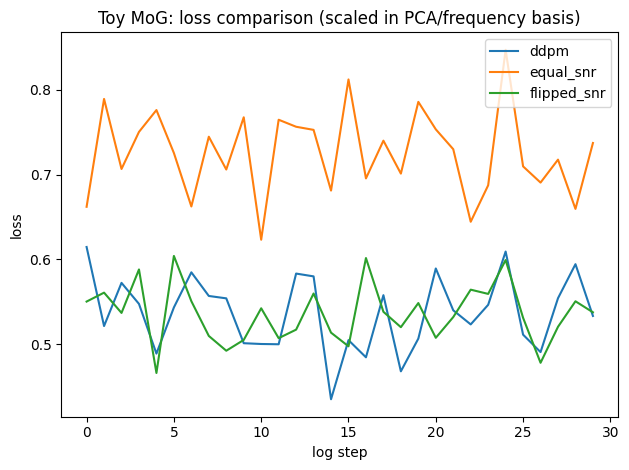

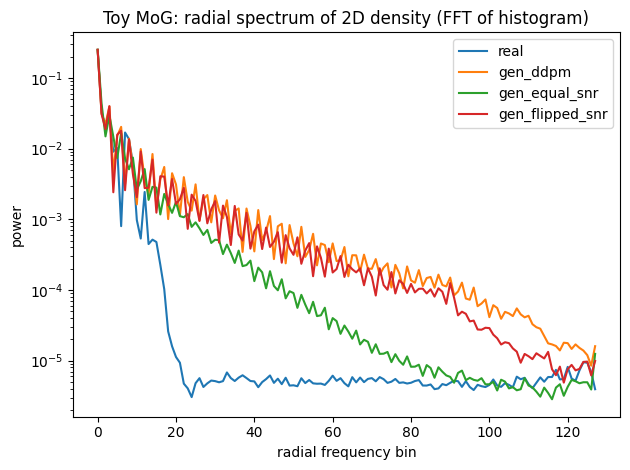

[mnist ddpm mask=none] step 200/8000 loss 0.2154
[mnist ddpm mask=none] step 400/8000 loss 0.2208
[mnist ddpm mask=none] step 600/8000 loss 0.2103
[mnist ddpm mask=none] step 800/8000 loss 0.1930
[mnist ddpm mask=none] step 1000/8000 loss 0.1858
[mnist ddpm mask=none] step 1200/8000 loss 0.1856
[mnist ddpm mask=none] step 1400/8000 loss 0.1956
[mnist ddpm mask=none] step 1600/8000 loss 0.1999
[mnist ddpm mask=none] step 1800/8000 loss 0.1882
[mnist ddpm mask=none] step 2000/8000 loss 0.1766


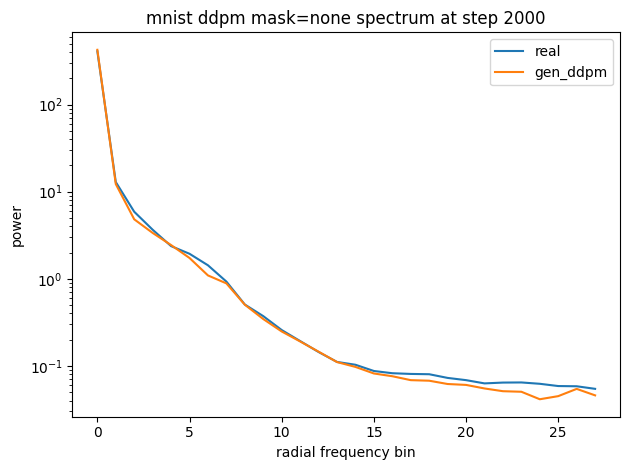

[mnist ddpm mask=none] step 2200/8000 loss 0.2031
[mnist ddpm mask=none] step 2400/8000 loss 0.1871
[mnist ddpm mask=none] step 2600/8000 loss 0.1995
[mnist ddpm mask=none] step 2800/8000 loss 0.1797
[mnist ddpm mask=none] step 3000/8000 loss 0.1841
[mnist ddpm mask=none] step 3200/8000 loss 0.1811
[mnist ddpm mask=none] step 3400/8000 loss 0.1869
[mnist ddpm mask=none] step 3600/8000 loss 0.1867
[mnist ddpm mask=none] step 3800/8000 loss 0.2057
[mnist ddpm mask=none] step 4000/8000 loss 0.1732


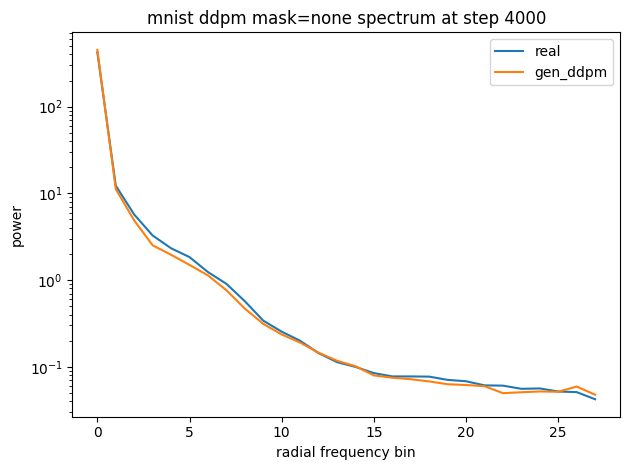

In [ ]:

# train_diffusion_equal_snr.ipynb
# 1) Toy mixture-of-Gaussians(2D) (DDPM vs EqualSNR vs FlippedSNR + frequency plots via FFT)
# 2) Binary MNIST (28x28) and CIFAR10 (32x32) with Fourier-space diffusion (DDPM vs EqualSNR vs FlippedSNR)
# 3) Masking experiments (pixel Bernoulli, random block, random half-plane) and their impact on frequency spectra

import os
import math
import time
from dataclasses import dataclass
from typing import Literal, Optional, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from diffusion_utils_equal_snr import (
    seed_all, get_device,
    FourierDiffusionConfig, FourierForwardProcess,
    SimpleUNet, ToyMLP,
    estimate_C_diag_rfft2,
    loss_x0_fourier_weighted, ddim_sample,
    radial_power_spectrum,
    mask_pixels_bernoulli, mask_random_block, mask_random_halfplane,
)

device = get_device()
seed_all(0)
print("device:", device)


@dataclass
class ExpConfig:
    T: int = 1000
    steps_ddim: int = 100
    lr: float = 2e-4
    batch_size: int = 128
    iters: int = 20000
    log_every: int = 200
    sample_every: int = 2000
    outdir: str = "./runs_equal_snr"

cfg = ExpConfig()
os.makedirs(cfg.outdir, exist_ok=True)

# Plotting
def plot_loss_curves(loss_hist: Dict[str, list], title: str, save_path: str):
    plt.figure()
    for k, v in loss_hist.items():
        plt.plot(v, label=k)
    plt.legend()
    plt.xlabel("log step")
    plt.ylabel("loss")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

def plot_radial_spectra(specs: Dict[str, torch.Tensor], title: str, save_path: str):
    plt.figure()
    for k, v in specs.items():
        plt.plot(v.detach().cpu().numpy(), label=k)
    plt.yscale("log")
    plt.xlabel("radial frequency bin")
    plt.ylabel("power")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()

# Toy dataset: Mixture of Gaussians in 2D
def make_mog(n: int = 200000, k: int = 8, radius: float = 4.0, std: float = 0.5, device=device):
    angles = torch.linspace(0, 2*math.pi, k+1, device=device)[:-1]
    centers = torch.stack([radius*torch.cos(angles), radius*torch.sin(angles)], dim=1)  # (k,2)
    idx = torch.randint(0, k, (n,), device=device)
    x = centers[idx] + std * torch.randn(n, 2, device=device)
    return x

toy_data = make_mog().detach().cpu()
toy_loader = DataLoader(TensorDataset(toy_data), batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

class ToyForwardProcess:
    # simple DDPM/EqualSNR/FlippedSNR in coordinate space for 2D toy, using C from data covariance in rotated basis.
    def __init__(self, schedule: Literal["ddpm","equal_snr","flipped_snr"], T: int = 1000, device=device):
        self.schedule = schedule
        self.T = T
        betas = torch.linspace(1e-4, 2e-2, T, device=device)
        alphas = 1 - betas
        self.alpha_bar = torch.cumprod(alphas, 0).clamp(1e-8, 1-1e-8)
        # Estimate C in "frequency" = PCA basis
        X = toy_data.to(device).float()
        Xc = X - X.mean(0, keepdim=True)
        cov = (Xc.t() @ Xc) / Xc.shape[0]
        eigvals, eigvecs = torch.linalg.eigh(cov)
        self.U = eigvecs  # (2,2)
        self.C = eigvals.clamp_min(1e-8)  # (2,)
        if schedule == "ddpm":
            self.Sigma = torch.ones_like(self.C)
        elif schedule == "equal_snr":
            self.Sigma = self.C.clone()  # Σii = C_i, equalSNR
        else:
            self.Sigma = torch.flip(self.C, dims=[0]).reciprocal() * self.C  # C_i/C_{d-i}

    def sample_t(self, B: int):
        return torch.randint(1, self.T+1, (B,), device=device)

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor):
        B = x0.shape[0]
        ab = self.alpha_bar[t-1].view(B,1)
        # go to PCA basis
        y0 = x0 @ self.U
        eps = torch.randn_like(y0)
        eps_sigma = eps * torch.sqrt(self.Sigma).view(1,2)
        yt = torch.sqrt(ab)*y0 + torch.sqrt(1-ab)*eps_sigma
        xt = yt @ self.U.t()
        return xt, y0, yt

def train_toy(schedule: Literal["ddpm","equal_snr","flipped_snr"], iters: int = 10000):
    model = ToyMLP(dim=2).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

    fwd = ToyForwardProcess(schedule=schedule, T=cfg.T, device=device)
    losses=[]
    loader_iter = iter(toy_loader)

    for step in range(1, iters+1):
        try:
            (x0_cpu,) = next(loader_iter)
        except StopIteration:
            loader_iter = iter(toy_loader)
            (x0_cpu,) = next(loader_iter)
        x0 = x0_cpu.to(device).float()
        t = fwd.sample_t(x0.shape[0])

        xt, y0, yt = fwd.q_sample(x0, t)
        x0_hat = model(xt, t)
        # loss in frequency basis, scaled by C^{-1/2}
        y0_hat = x0_hat @ fwd.U
        diff = (y0 - y0_hat) / torch.sqrt(fwd.C).view(1,2)
        loss = (diff**2).mean()

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        if step % cfg.log_every == 0:
            losses.append(loss.item())
            print(f"[toy {schedule}] step {step}/{iters} loss {loss.item():.4f}")

    return model, losses

toy_models={}
toy_loss_hist={}
for sched in ["ddpm","equal_snr","flipped_snr"]:
    m, l = train_toy(sched, iters=6000)
    toy_models[sched]=m
    toy_loss_hist[sched]=l

plot_loss_curves(toy_loss_hist, "Toy MoG: loss comparison (scaled in PCA/frequency basis)", os.path.join(cfg.outdir, "toy_loss.png"))

# Toy frequency plot: approximate "Fourier" by 2D FFT of histogram density
@torch.no_grad()
def toy_hist_spectrum(samples: torch.Tensor, bins: int = 128, lim: float = 8.0) -> torch.Tensor:
    # samples: (N,2) on device
    x = samples
    # histogram in numpy
    x_cpu = x.detach().cpu().numpy()
    H, _, _ = np.histogram2d(x_cpu[:,0], x_cpu[:,1], bins=bins, range=[[-lim,lim],[-lim,lim]], density=True)
    H = torch.from_numpy(H).to(device).float().unsqueeze(0).unsqueeze(0)  # (1,1,bins,bins)
    spec = radial_power_spectrum(H)
    return spec

@torch.no_grad()
def toy_sample(model: nn.Module, fwd: ToyForwardProcess, n: int = 50000) -> torch.Tensor:
    # DDIM-like deterministic sampling in PCA basis
    B = n
    y = torch.randn(B,2, device=device) * torch.sqrt(fwd.Sigma).view(1,2)
    # timesteps
    steps = 200
    ts = torch.linspace(fwd.T, 1, steps, device=device).long()
    for i, t in enumerate(ts):
        t_batch = torch.full((B,), int(t.item()), device=device, dtype=torch.long)
        ab_t = fwd.alpha_bar[t-1].view(1,1)
        x = y @ fwd.U.t()
        x0_hat = model(x, t_batch)
        y0_hat = x0_hat @ fwd.U
        if i == len(ts)-1:
            return x0_hat
        t_prev = ts[i+1]
        ab_prev = fwd.alpha_bar[t_prev-1].view(1,1)
        eps = (y - torch.sqrt(ab_t)*y0_hat)/torch.sqrt(1-ab_t)
        y = torch.sqrt(ab_prev)*y0_hat + torch.sqrt(1-ab_prev)*eps
    return (y @ fwd.U.t())

toy_specs={}
real_spec = toy_hist_spectrum(make_mog(n=50000, device=device))
toy_specs["real"]=real_spec
for sched in ["ddpm","equal_snr","flipped_snr"]:
    fwd = ToyForwardProcess(schedule=sched, T=cfg.T, device=device)
    samp = toy_sample(toy_models[sched], fwd, n=50000)
    toy_specs[f"gen_{sched}"]=toy_hist_spectrum(samp)
plot_radial_spectra(toy_specs, "Toy MoG: radial spectrum of 2D density (FFT of histogram)", os.path.join(cfg.outdir, "toy_spectrum.png"))

# Binary MNIST and CIFAR10
def get_binary_mnist(batch_size: int):
    tfm = T.Compose([
        T.ToTensor(),
        lambda x: (x > 0.5).float(),  # binarize
        lambda x: x * 2 - 1,          # to [-1,1]
    ])
    ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    return ds, dl

def get_cifar10(batch_size: int):
    tfm = T.Compose([
        T.ToTensor(),
        lambda x: x * 2 - 1,  # to [-1,1]
    ])
    ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    return ds, dl

def train_image_dataset(
    name: str,
    loader: DataLoader,
    in_ch: int,
    schedule: Literal["ddpm","equal_snr","flipped_snr"],
    mask_mode: Optional[Literal["none","bernoulli","block","halfplane"]] = "none",
    iters: int = 20000,
    n_C_batches: int = 200,
):
    model = SimpleUNet(in_ch=in_ch, base=64, t_dim=128).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

    # Estimate C_diag for equal_snr / flipped_snr
    C_diag = None
    if schedule != "ddpm":
        C_diag = estimate_C_diag_rfft2(loader, device=device, n_batches=n_C_batches)

    fwd = FourierForwardProcess(
        FourierDiffusionConfig(T=cfg.T, schedule=schedule, calibrate_alpha_bar=True),
        C_diag=C_diag,
        device=device,
    )

    loss_log=[]
    loader_iter = iter(loader)

    for step in range(1, iters+1):
        try:
            x0, _ = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x0, _ = next(loader_iter)
        x0 = x0.to(device, non_blocking=True).float()

        if mask_mode == "bernoulli":
            x0 = mask_pixels_bernoulli(x0, p_zero=0.5)
        elif mask_mode == "block":
            x0 = mask_random_block(x0, frac=0.4)
        elif mask_mode == "halfplane":
            x0 = mask_random_halfplane(x0)

        t = fwd.sample_t(x0.shape[0])
        loss, _ = loss_x0_fourier_weighted(model, fwd, x0, t)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % cfg.log_every == 0:
            loss_log.append(loss.item())
            print(f"[{name} {schedule} mask={mask_mode}] step {step}/{iters} loss {loss.item():.4f}")

        if step % cfg.sample_every == 0:
            model.eval()
            with torch.no_grad():
                samples = ddim_sample(model, fwd, (64, in_ch, x0.shape[-2], x0.shape[-1]), steps=cfg.steps_ddim)
            model.train()
            # spectra compare: real batch vs samples
            real_spec = radial_power_spectrum(x0[:64])
            gen_spec = radial_power_spectrum(samples.clamp(-1,1))
            plot_radial_spectra(
                {"real": real_spec, f"gen_{schedule}": gen_spec},
                f"{name} {schedule} mask={mask_mode} spectrum at step {step}",
                os.path.join(cfg.outdir, f"{name}_{schedule}_{mask_mode}_spec_step{step}.png"),
            )

    return model, fwd, loss_log

# Run MNIST experiments
mnist_ds, mnist_dl = get_binary_mnist(cfg.batch_size)
mnist_results = {}
for sched in ["ddpm","equal_snr","flipped_snr"]:
    model, fwd, losses = train_image_dataset("mnist", mnist_dl, in_ch=1, schedule=sched, mask_mode="none", iters=8000)
    mnist_results[(sched,"none")] = (model, fwd, losses)

plot_loss_curves(
    {f"{k[0]}": v[2] for k,v in mnist_results.items()},
    "Binary MNIST: loss (baseline vs EqualSNR vs FlippedSNR)",
    os.path.join(cfg.outdir, "mnist_loss.png"),
)

# Run CIFAR10 experiments
cifar_ds, cifar_dl = get_cifar10(cfg.batch_size)
cifar_results = {}
for sched in ["ddpm","equal_snr","flipped_snr"]:
    model, fwd, losses = train_image_dataset("cifar10", cifar_dl, in_ch=3, schedule=sched, mask_mode="none", iters=8000)
    cifar_results[(sched,"none")] = (model, fwd, losses)

plot_loss_curves(
    {f"{k[0]}": v[2] for k,v in cifar_results.items()},
    "CIFAR10: loss (baseline vs EqualSNR vs FlippedSNR)",
    os.path.join(cfg.outdir, "cifar_loss.png"),
)
# MNIST with Bernoulli masking vs none
mnist_mask_results = {}
for mask_mode in ["bernoulli","block","halfplane"]:
    for sched in ["ddpm","equal_snr"]:
        model, fwd, losses = train_image_dataset("mnist", mnist_dl, in_ch=1, schedule=sched, mask_mode=mask_mode, iters=6000)
        mnist_mask_results[(sched,mask_mode)] = (model, fwd, losses)

# Plot masking losses
loss_dict = {f"{sched}_{mask}": mnist_mask_results[(sched,mask)][2] for (sched,mask) in mnist_mask_results.keys()}
plot_loss_curves(loss_dict, "Binary MNIST masking: loss comparison (DDPM vs EqualSNR)", os.path.join(cfg.outdir, "mnist_mask_loss.png"))

print("Done. Outputs saved to:", cfg.outdir)


In [ ]:

%%writefile diffusion_utils.py
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
import torch.nn as nn
from typing import Optional
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
import ot

# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @property
    @abstractmethod
    def dim(self) -> int:
        """
        Returns:
            - Dimensionality of the distribution
        """
        pass
        
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass
class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass
class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Multivariate Gaussian distribution
    """
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        """
        mean: shape (dim,)
        cov: shape (dim,dim)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))
        
    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)
class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)
        self.P = torch.randn((20,self.dim)).to(device)
        self.P = self.P/torch.norm(self.P, dim=0, keepdim=True)
        #self.discrete = self.sample_projected(2000).to(device)
        self.discrete = self.sample(2000).to(device)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    def sample_projected(self, num_samples: int) -> torch.Tensor:
        sample = self.distribution.sample(torch.Size((num_samples,))).to(device) 
        return (self.P[None,:,:]@sample[:,:,None]).squeeze()
    
    def sample_discrete(self, num_samples: int) -> torch.Tensor:
        idx = torch.randint(0, self.discrete.shape[0], (num_samples,)).to(device)
        sample = self.discrete[idx].to(device)
        return sample

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0])
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

    @classmethod
    def symmetric_4D(
        cls, nmodes: int, std: float
    ) -> "GaussianMixture":
        # 4D unit hypersphere samples
        means = torch.randn(nmodes,20)              # standard normal in R^2
        means = means / means.norm(dim=1, keepdim=True)  # normalize to unit length

        # isotropic covariance
        covs = torch.diag_embed(torch.ones(nmodes, 20) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass
class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape (batch_size, 1)
        Returns:
            - diffusion_coefficient: shape (batch_size, dim)
        """
        pass
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape (bs,1)
            - dt: time, shape (bs,1)
        Returns:
            - nxt: state at time t + dt (bs, dim)
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (bs, num_timesteps,1)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[:, t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (bs, num_timesteps, 1)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num
            _timesteps, dim)
        """
        xs = [x.clone()]
        nts = ts.shape[1]
        for t_idx in tqdm(range(nts - 1)):
            t = ts[:,t_idx]
            h = ts[:, t_idx + 1] - ts[:, t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.ode.drift_coefficient(xt,t) * h
class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.sde.drift_coefficient(xt,t) * h + self.sde.diffusion_coefficient(xt,t) * torch.sqrt(h) * torch.randn_like(xt)

class ConditionalProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, dim)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, dim)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, dim)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """ 
        pass
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )
class Alpha(ABC):
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.zeros(1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1)), torch.ones(1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 0.0, self(1.0) = 1.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """ 
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)  
class Beta(ABC):
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1)), torch.ones(1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1)), torch.zeros(1,1)
        )
        
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates alpha_t. Should satisfy: self(0.0) = 1.0, self(1.0) = 0.0.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        pass 

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt beta_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt beta_t (num_samples, 1)
        """ 
        t = t.unsqueeze(1) # (num_samples, 1, 1)
        dt = vmap(jacrev(self))(t) # (num_samples, 1, 1, 1, 1)
        return dt.view(-1, 1)
class LinearAlpha(Alpha):
    """
    Implements alpha_t = t
    """
    
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """ 
        return t 
        
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        return torch.ones_like(t)
class SquareRootBeta(Beta):
    """
    Implements beta_t = rt(1-t)
    """
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """ 
        return torch.sqrt(1-t)

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """ 
        return - 0.5 / (torch.sqrt(1 - t) + 1e-4)
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, alpha: Alpha, beta: Beta):
        # infer dimension from p_data
        x0 = p_data.sample(1)
        aux_dim = x0.shape[-1]

        p_simple = Gaussian.isotropic(aux_dim, 1.0)
        super().__init__(p_simple, p_data)

        self.alpha = alpha
        self.beta = beta
        self.p_data = p_data


    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z ~ p_data(x)
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        #return self.p_data.sample_projected(num_samples)
        #return self.p_data.sample_discrete(num_samples)
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        return self.alpha(t)*z+self.beta(t)*torch.randn_like(z) 
        
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        return (self.alpha.dt(t)-self.beta.dt(t)/self.beta(t)*self.alpha(t))*z + self.beta.dt(t)/self.beta(t)*x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z) = N(alpha_t * z, beta_t**2 * I_d)
        Note: Only defined on t in [0,1)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """ 
        return -(x - self.alpha(t)*z)/self.beta(t)**2

class ConditionalVectorFieldODE(ODE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t)
class ConditionalVectorFieldSDE(SDE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, ...)
        """
        super().__init__()
        self.path = path
        self.z = z
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t) + 0.5 * self.sigma**2 * self.path.conditional_score(x,z,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)
def build_mlp(dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)
class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)                
class MLPScore(torch.nn.Module):
    """
    MLP-parameterization of the learned score field
    """
    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = build_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - s_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        M = torch.randn((self.dim,self.dim)).to(device)
        A = (M - M.T) / 2.0
        return self.net(xt) #+ (A[None,:,:]@x[:,:,None]).squeeze()        
    
    #def forward_curl(self, x: torch.Tensor, t: torch.Tensor):
    #    return self.forward(x,t) + 0.1*self.A@x
   
class Trainer(ABC):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model

    @abstractmethod
    def get_train_loss(self, **kwargs) -> torch.Tensor:
        pass

    def get_optimizer(self, lr: float):
        return torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, num_epochs: int, device: torch.device, lr: float = 1e-3, **kwargs) -> torch.Tensor:
        # Start
        self.model.to(device)
        opt = self.get_optimizer(lr)
        self.model.train()

        # Train loop
        pbar = tqdm(enumerate(range(num_epochs)))
        for idx, epoch in pbar:
            opt.zero_grad()
            loss = self.get_train_loss(**kwargs)
            loss.backward()
            opt.step()
            pbar.set_description(f'Epoch {idx}, loss: {loss.item()}')

        # Finish
        self.model.eval()            
class ConditionalScoreMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPScore, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        #z = self.path.p_data.sample_discrete(batch_size)
        #z = self.path.p_data.sample_projected(batch_size)
        z = self.path.p_data.sample(batch_size)
        t = torch.rand(batch_size,1).to(device)
        x = self.path.sample_conditional_path(z,t)
        loss = torch.nn.MSELoss()
        return loss(self.model(x,t), self.path.conditional_score(x,z,t))
class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: ConditionalProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
        #z = self.path.p_data.sample_discrete(batch_size)
        #z = self.path.p_data.sample_projected(batch_size)
        z = self.path.p_data.sample(batch_size)
        t = torch.rand(batch_size,1).to(device)
        x = self.path.sample_conditional_path(z,t)
        loss = torch.nn.MSELoss()
        return loss(self.model(x,t), self.path.conditional_vector_field(x,z,t))

class LearnedVectorFieldODE(ODE):

    def __init__(self, net: MLPVectorField):
        self.net = net

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: (bs, dim)
            - t: (bs, dim)
        Returns:
            - u_t: (bs, dim)
        """
        return self.net(x, t)
class LangevinFlowSDE(SDE):
    def __init__(self, flow_model: MLPVectorField, score_model: MLPScore, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, dim)
        """
        super().__init__()
        self.flow_model = flow_model
        self.score_model = score_model
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.flow_model(x,t) + 0.5 * self.sigma ** 2 * self.score_model(x, t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)
class ScoreFromVectorField(torch.nn.Module):
    """
    Parameterization of score via learned vector field (for the special case of a Gaussian conditional probability path)
    """
    def __init__(self, vector_field: MLPVectorField, alpha: Alpha, beta: Beta):
        super().__init__()
        self.vector_field = vector_field
        self.alpha = alpha
        self.beta = beta

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - score: (bs, dim)
        """
        return (self.alpha(t)*self.vector_field(x,t)-self.alpha.dt(t)*x)/(self.beta(t)**2*self.alpha.dt(t)-self.alpha(t)*self.beta.dt(t)*self.beta(t))
class VectorFieldFromScore(torch.nn.Module):
    """
    Parameterization of score via learned vector field (for the special case of a Gaussian conditional probability path)
    """
    def __init__(self, score: MLPScore, alpha: Alpha, beta: Beta):
        super().__init__()
        self.score = score
        self.alpha = alpha
        self.beta = beta

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - vector_field: (bs, dim)
        """
        return self.alpha.dt(t)/self.alpha(t)*x + (self.beta(t)**2*self.alpha.dt(t)/self.alpha(t)-self.beta.dt(t)*self.beta(t))*self.score(x,t)

def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])
    
    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)
def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)
def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)
def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu(), y=samples[:,1].cpu(), ax=ax, **kwargs)
def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)
def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

def compare_scores(path,flow_model,score_model):
    #######################
    # Change these values #
    #######################
    num_bins = 30
    num_marginals = 4

    #########################
    # Define score networks #
    #########################
    learned_score_model = score_model
    flow_score_model = ScoreFromVectorField(flow_model, path.alpha, path.beta)


    ###############################
    # Plot score fields over time #
    ###############################
    fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 12))
    axes = axes.reshape((2, num_marginals))

    scale = PARAMS["scale"]
    x_bounds = [-scale,scale]
    y_bounds = [-scale,scale]

    ts = torch.linspace(0.01, 0.9999, num_marginals).to(device)
    xs = torch.linspace(-scale, scale, num_bins).to(device)
    ys = torch.linspace(-scale, scale, num_bins).to(device)
    xx, yy = torch.meshgrid(xs, ys)
    xx = xx.reshape(-1,1)
    yy = yy.reshape(-1,1)
    xy = torch.cat([xx,yy], dim=-1)

    axes[0,0].set_ylabel("Learned with Score Matching", fontsize=12)
    axes[1,0].set_ylabel("Computed from $u_t^{{\\theta}}(x)$", fontsize=12)
    for idx in range(num_marginals):
        t = ts[idx]
        bs = num_bins ** 2
        tt = t.view(1,1).expand(bs, 1)
        
        # Learned scores
        learned_scores = learned_score_model(xy, tt)
        learned_scores_x = learned_scores[:,0]
        learned_scores_y = learned_scores[:,1]

        ax = axes[0, idx]
        ax.quiver(xx.detach().cpu(), yy.detach().cpu(), learned_scores_x.detach().cpu(), learned_scores_y.detach().cpu(), scale=125, alpha=0.5)
        imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
        imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax.set_title(f'$s_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
        ax.set_xticks([])
        ax.set_yticks([])
        

        # Flow score model
        ax = axes
        flow_scores = flow_score_model(xy,tt)
        flow_scores_x = flow_scores[:,0]
        flow_scores_y = flow_scores[:,1]

        ax = axes[1, idx]
        ax.quiver(xx.detach().cpu(), yy.detach().cpu(), flow_scores_x.detach().cpu(), flow_scores_y.detach().cpu(), scale=125, alpha=0.5)
        imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
        imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax.set_title(f'$\\tilde{{s}}_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig("compare_scores.pdf", bbox_inches="tight")
def compare_vector_fields(path,flow_model,score_model):
    #######################
    # Change these values #
    #######################
    num_bins = 30
    num_marginals = 4

    #########################
    # Define score networks #
    #########################
    learned_flow_model = flow_model 
    score_flow_model = VectorFieldFromScore(score_model, path.alpha, path.beta)

    ###############################
    # Plot score fields over time #
    ###############################
    fig, axes = plt.subplots(2, num_marginals, figsize=(6 * num_marginals, 12))
    axes = axes.reshape((2, num_marginals))

    scale = PARAMS["scale"]
    x_bounds = [-scale,scale]
    y_bounds = [-scale,scale]

    ts = torch.linspace(0.01, 0.9999, num_marginals).to(device)
    xs = torch.linspace(-scale, scale, num_bins).to(device)
    ys = torch.linspace(-scale, scale, num_bins).to(device)
    xx, yy = torch.meshgrid(xs, ys)
    xx = xx.reshape(-1,1)
    yy = yy.reshape(-1,1)
    xy = torch.cat([xx,yy], dim=-1)

    axes[0,0].set_ylabel("Learned with Flow Matching", fontsize=12)
    axes[1,0].set_ylabel("Computed from $s_t^{{\\theta}}(x)$", fontsize=12)
    for idx in range(num_marginals):
        t = ts[idx]
        bs = num_bins ** 2
        tt = t.view(1,1).expand(bs, 1)
        
        # Learned scores
        learned_vector_field = learned_flow_model(xy, tt)
        learned_vector_field_x = learned_vector_field[:,0]
        learned_vector_field_y = learned_vector_field[:,1]

        ax = axes[0, idx]
        ax.quiver(xx.detach().cpu(), yy.detach().cpu(), learned_vector_field_x.detach().cpu(), learned_vector_field_y.detach().cpu(), scale=125, alpha=0.5)
        imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
        imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax.set_title(f'$u_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
        ax.set_xticks([])
        ax.set_yticks([])
        

        # Flow score model
        ax = axes
        score_flows = score_flow_model(xy,tt)
        score_flows_x = score_flows[:,0]
        score_flows_y = score_flows[:,1]

        ax = axes[1, idx]
        ax.quiver(xx.detach().cpu(), yy.detach().cpu(), score_flows_x.detach().cpu(), score_flows_y.detach().cpu(), scale=125, alpha=0.5)
        imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
        imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax.set_title(f'$\\tilde{{u}}_{{t}}^{{\\theta}}$ at t={t.item():.2f}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig("compare_vector_fields.pdf", bbox_inches="tight")

def plot_flow(path,flow_model,num_timesteps,output_file):
    #######################
    # Change these values #
    #######################
    num_samples = 1000
    num_marginals = 3

    ##############
    # Setup Plot #
    ##############
    scale = PARAMS["scale"]
    x_bounds = [-scale,scale]
    y_bounds = [-scale,scale]
    legend_size=24
    markerscale=1.8

    # Setup figure
    fig, axes = plt.subplots(1,3, figsize=(36, 12))

    ###########################################
    # Graph Samples from Learned Marginal ODE #
    ###########################################
    ax = axes[1]

    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

    # Construct integrator and plot trajectories
    ode = LearnedVectorFieldODE(flow_model)
    simulator = EulerSimulator(ode)
    x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
    ts = torch.linspace(0.01, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
    xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

    # Extract every n-th integration step to plot
    every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
    xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
    ts_every_n = ts[0,every_n] # (nts // n,)
    for plot_idx in range(xts_every_n.shape[1]):
        tt = ts_every_n[plot_idx].item()
        ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

    ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

    ##############################################
    # Graph Trajectories of Learned Marginal ODE #
    ##############################################
    ax = axes[2]
    ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

    for traj_idx in range(num_samples // 10):
        ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

    ################################################
    # Graph Ground-Truth Marginal Probability Path #
    ################################################
    ax = axes[0]
    ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

    for plot_idx in range(xts_every_n.shape[1]):
        tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
        marginal_samples = path.sample_marginal_path(tt)
        ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

    ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)
        
    plt.savefig(output_file, bbox_inches="tight")
def plot_score(path,flow_model,score_model,num_timesteps,output_file):
    #######################
    # Change these values #
    #######################
    num_samples = 1000
    num_marginals = 3
    sigma = 2.0 # Don't set sigma too large or you'll get numerical issues!

    ##############
    # Setup Plot #
    ##############
    scale = PARAMS["scale"]
    x_bounds = [-scale,scale]
    y_bounds = [-scale,scale]
    legend_size = 24
    markerscale = 1.8

    # Setup figure
    fig, axes = plt.subplots(1,3, figsize=(36, 12))

    ###########################################
    # Graph Samples from Learned Marginal SDE #
    ###########################################
    ax = axes[1]
    ax.set_title("Samples from Learned Marginal SDE", fontsize=20)
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


    # Construct integrator and plot trajectories
    sde = LangevinFlowSDE(flow_model, score_model, sigma)
    simulator = EulerMaruyamaSimulator(sde)
    x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
    ts = torch.linspace(0.01, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
    xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

    # Extract every n-th integration step to plot
    every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
    xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
    ts_every_n = ts[0,every_n] # (nts // n,)
    for plot_idx in range(xts_every_n.shape[1]):
        tt = ts_every_n[plot_idx].item()
        ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

    ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

    ###############################################
    # Graph Trajectories of Learned Marginal SDE  #
    ###############################################
    ax = axes[2]
    ax.set_title("Trajectories of Learned Marginal SDE", fontsize=20)
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

    for traj_idx in range(num_samples // 10):
        ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

    ################################################
    # Graph Ground-Truth Marginal Probability Path #
    ################################################
    ax = axes[0]
    ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

    for plot_idx in range(xts_every_n.shape[1]):
        tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
        marginal_samples = path.sample_marginal_path(tt)
        ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

    # Plot source and target
    imshow_density(density=path.p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
    imshow_density(density=path.p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

    ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)
        
    plt.savefig(output_file, bbox_inches="tight")
def wasserstein_distance(samples, target_samples):
    n = len(samples)
    # Uniform weights for empirical distributions
    a = torch.ones(n,device=device) / n
    b = torch.ones(n,device=device) / n

    # Pairwise cost matrix (Euclidean distances)
    M = ot.dist(samples, target_samples, metric='euclidean')  # shape (n, n)

    # --- Solve optimal transport ---
    res = ot.solve(M, a, b)
    return res.value
def simulate_flow(path,flow_model,num_samples,num_timesteps):
    # Construct integrator and plot trajectories
    ode = LearnedVectorFieldODE(flow_model)
    simulator = EulerSimulator(ode)
    x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
    ts = torch.linspace(0.01, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
    xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)
    x1 = xts[:,-1,:]
    return x1
def simulate_score(path,flow_model,score_model,num_samples,num_timesteps):
    # Construct integrator and plot trajectories
    sigma = 2.0
    sde = LangevinFlowSDE(flow_model,score_model,sigma)
    simulator = EulerMaruyamaSimulator(sde)
    x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
    ts = torch.linspace(0.01, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
    xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)
    x1 = xts[:,-1,:]
    return x1
def plot_results(results):
    # -------------------------------------------------------
    # Plot Wasserstein vs. timesteps (from `results` dict)
    # -------------------------------------------------------
    plt.figure(figsize=(6,5))

    # plot flow model curve
    if "flow_deterministic" in results:
        steps, Ws = results["flow_deterministic"]
        plt.plot(steps, Ws, marker="o", linewidth=2, label="Flow model (deterministic)")

    if "flow_stochastic" in results:
        steps, Ws = results["flow_stochastic"]
        plt.plot(steps, Ws, marker="o", linewidth=2, label="Flow model (stochastic)")

    # plot score model curve
    if "score_stochastic" in results:
        steps, Ws = results["score_stochastic"]
        plt.plot(steps, Ws, marker="s", linewidth=2, label="Score model (stochastic)")

    if "score_deterministic" in results:
        steps, Ws = results["score_deterministic"]
        plt.plot(steps, Ws, marker="s", linewidth=2, label="Score model (deterministic)")

    plt.ylabel("Error (Wasserstein-1 distance)", fontsize=14)
    plt.xlabel("Iterations (timesteps)", fontsize=14)
    plt.title("Convergence of Simulation Error vs Iterations", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()

    # -------------------------------------------------------
    # Save plot as PDF
    # -------------------------------------------------------
    plt.savefig("./convergence.pdf", bbox_inches="tight")
# ============================================================
# Fourier-space EqualSNR / FlippedSNR + frequency diagnostics
# Additive utilities; DOES NOT replace your original classes.
# ============================================================

from dataclasses import dataclass
from typing import Optional, Tuple, Dict

def du_rfft2(x: torch.Tensor) -> torch.Tensor:
    return torch.fft.rfft2(x, dim=(-2, -1), norm="ortho")

def du_irfft2(y: torch.Tensor, h: int, w: int) -> torch.Tensor:
    return torch.fft.irfft2(y, s=(h, w), dim=(-2, -1), norm="ortho")

def du_cosine_alpha_bar(t: torch.Tensor, s: float = 0.008) -> torch.Tensor:
    t = torch.clamp(t, 0.0, 1.0)
    f = torch.cos((t + s) / (1.0 + s) * math.pi / 2.0) ** 2
    f0 = math.cos(s / (1.0 + s) * math.pi / 2.0) ** 2
    return f / f0

def du_get_alpha_sigma(alpha_bar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    a = torch.sqrt(torch.clamp(alpha_bar, 1e-12, 1.0))
    s = torch.sqrt(torch.clamp(1.0 - alpha_bar, 0.0, 1.0))
    return a, s

@torch.no_grad()
def du_estimate_C_diag_rfft2(loader, device: torch.device, n_batches: int = 200, eps: float = 1e-8) -> torch.Tensor:
    """
    Estimate C_i ≈ E[|y0_i|^2] in rFFT2 domain.
    Returns shape: (C, H, W//2+1).
    """
    acc = None
    count = 0
    for i, batch in enumerate(loader):
        if i >= n_batches:
            break
        x = batch[0] if isinstance(batch, (tuple, list)) else batch
        x = x.to(device, non_blocking=True).float()
        y = du_rfft2(x)
        p = (y.real ** 2 + y.imag ** 2).mean(dim=0)
        acc = p if acc is None else (acc + p)
        count += 1
    if acc is None:
        raise RuntimeError("du_estimate_C_diag_rfft2: no batches read")
    acc = acc / max(1, count)
    return torch.clamp(acc, min=eps)

def du_calibrate_equal_snr_alpha_bar(alpha_bar_ddpm: torch.Tensor, C_diag: torch.Tensor) -> torch.Tensor:
    """
    Fourier-space paper Appendix A.3: equalize average SNR by adjusting alpha_bar.
    Implements: a_eq = (a*meanC) / ((1-a)+a*meanC)
    """
    meanC = C_diag.mean()
    ab = torch.clamp(alpha_bar_ddpm, 1e-12, 1.0 - 1e-12)
    ab_eq = (ab * meanC) / ((1.0 - ab) + ab * meanC)
    return torch.clamp(ab_eq, 1e-12, 1.0 - 1e-12)

def du_rfft2_radial_grid(h: int, w: int, device: torch.device, dtype: torch.dtype = torch.float32) -> torch.Tensor:
    fy = torch.fft.fftfreq(h, d=1.0, device=device).to(dtype)
    fx = torch.fft.rfftfreq(w, d=1.0, device=device).to(dtype)
    yy, xx = torch.meshgrid(fy, fx, indexing="ij")
    rr = torch.sqrt(xx * xx + yy * yy)
    rmax = torch.sqrt(torch.tensor(0.5, device=device, dtype=dtype) ** 2 + torch.tensor(0.5, device=device, dtype=dtype) ** 2)
    return rr / torch.clamp(rmax, min=1e-12)

def du_curriculum_band_limits(progress: float, mode: str, r_min: float = 0.0, r_max: float = 1.0, warmup: float = 0.05) -> Tuple[float, float]:
    p = float(max(0.0, min(1.0, progress)))
    if warmup > 0.0 and p < warmup:
        pe = 0.0
    else:
        pe = (p - warmup) / max(1e-12, (1.0 - warmup))

    if mode == "low_to_high":
        r_high = r_min + (r_max - r_min) * (0.05 + 0.95 * pe)
        return (r_min, float(min(r_high, r_max)))

    if mode == "high_to_low":
        r_low = r_max - (r_max - r_min) * (0.05 + 0.95 * pe)
        return (float(max(r_low, r_min)), r_max)

    raise ValueError(f"Unknown curriculum mode: {mode}")

def du_make_sigma_diag(scheme: str, C_diag: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Sigma choices:
      - ddpm: Sigma = I (pixel baseline)
      - equal_snr: Sigma = C
      - flipped_snr: Sigma = C / flip(C) using radial bins
    """
    if scheme == "ddpm":
        return torch.ones_like(C_diag)

    if scheme == "equal_snr":
        return torch.clamp(C_diag, min=eps)

    if scheme == "flipped_snr":
        device = C_diag.device
        C, H, Wr = C_diag.shape
        W = (Wr - 1) * 2
        r = du_rfft2_radial_grid(H, W, device=device, dtype=torch.float32)

        nb = max(8, int(min(H, W) / 2))
        bins = torch.clamp((r * (nb - 1)).round().long(), 0, nb - 1)

        C_bin = torch.zeros((C, nb), device=device, dtype=C_diag.dtype)
        counts = torch.zeros((nb,), device=device, dtype=C_diag.dtype)

        for b in range(nb):
            m = (bins == b)
            c = m.sum().item()
            if c == 0:
                continue
            counts[b] = c
            C_bin[:, b] = C_diag[:, m].mean(dim=1)

        C_bin = C_bin / torch.clamp(counts, min=1.0)[None, :]
        C_bin = torch.clamp(C_bin, min=eps)

        C_flip = C_bin[:, torch.arange(nb - 1, -1, -1, device=device)]
        ratio_bin = C_bin / torch.clamp(C_flip, min=eps)

        Sigma = torch.empty_like(C_diag)
        for b in range(nb):
            Sigma[:, bins == b] = ratio_bin[:, b].unsqueeze(1)

        return torch.clamp(Sigma, min=eps)

    raise ValueError(f"Unknown scheme: {scheme}")

@dataclass
class FourierDiffusionConfig:
    T: int = 1000
    schedule: str = "ddpm"  # "ddpm" | "equal_snr" | "flipped_snr"
    calibrate_alpha_bar: bool = True

class FourierForwardProcess:
    """
    Additive: This is separate from your GaussianConditionalProbabilityPath.
    It only supports image-like tensors: (B,C,H,W).
    """
    def __init__(self, cfg: FourierDiffusionConfig, C_diag: Optional[torch.Tensor], device: torch.device):
        self.cfg = cfg
        self.device = device
        self.C_diag = C_diag

        t_grid = torch.linspace(0.0, 1.0, steps=cfg.T + 1, device=device)
        ab = du_cosine_alpha_bar(t_grid)

        if cfg.schedule != "ddpm" and cfg.calibrate_alpha_bar and C_diag is not None:
            ab = du_calibrate_equal_snr_alpha_bar(ab, C_diag)

        self.alpha_bar = ab
        self.Sigma_diag = None
        if cfg.schedule != "ddpm" and C_diag is not None:
            self.Sigma_diag = du_make_sigma_diag(cfg.schedule, C_diag)

    def sample_t(self, batch: int) -> torch.Tensor:
        ti = torch.randint(0, self.cfg.T + 1, (batch,), device=self.device)
        return ti.float() / float(self.cfg.T)

    def _alpha_bar_at(self, t: torch.Tensor) -> torch.Tensor:
        idx = torch.clamp((t * self.cfg.T).round().long(), 0, self.cfg.T)
        return self.alpha_bar[idx]

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        B, C, H, W = x0.shape
        ab = self._alpha_bar_at(t)
        a, s = du_get_alpha_sigma(ab)
        a = a.view(B, 1, 1, 1)
        s = s.view(B, 1, 1, 1)

        if self.cfg.schedule == "ddpm" or self.Sigma_diag is None:
            eps = torch.randn_like(x0)
            xt = a * x0 + s * eps
            return xt, {}

        y0 = du_rfft2(x0)
        re = torch.randn_like(y0.real)
        im = torch.randn_like(y0.real)
        z = torch.complex(re, im)

        Sigma = self.Sigma_diag.unsqueeze(0)  # (1,C,H,Wr)
        eps_hat = torch.sqrt(Sigma) * z
        yt = a * y0 + s * eps_hat
        xt = du_irfft2(yt, H, W)

        return xt, {"y0": y0, "yt": yt}

def du_loss_x0_fourier_weighted(model: nn.Module, fwd: FourierForwardProcess, x0: torch.Tensor, t: torch.Tensor, band_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
    """
    Algorithm-1 style Fourier loss:
      L = || (y0 - y0hat) / sqrt(C) ||^2  (optionally restricted to a radial band mask)
    """
    xt, aux = fwd.q_sample(x0, t)
    x0_hat = model(xt, t)

    if (fwd.cfg.schedule == "ddpm" or fwd.C_diag is None) and band_mask is None:
        return F.mse_loss(x0_hat, x0)

    y0 = aux.get("y0", du_rfft2(x0))
    y0_hat = du_rfft2(x0_hat)

    Cdiag = torch.ones_like(y0.real[0]) if fwd.C_diag is None else fwd.C_diag
    Cdiag = Cdiag.unsqueeze(0)  # (1,C,H,Wr)

    diff = (y0 - y0_hat) / torch.sqrt(Cdiag)

    if band_mask is not None:
        bm = band_mask.unsqueeze(0).unsqueeze(0) if band_mask.dim() == 2 else band_mask
        diff = diff * bm

    return (diff.real ** 2 + diff.imag ** 2).mean()

@torch.no_grad()
def du_ddim_sample(model: nn.Module, fwd: FourierForwardProcess, shape: Tuple[int,int,int,int], steps: int = 200) -> torch.Tensor:
    """
    Deterministic DDIM-like sampler:
      - DDPM baseline: sample in pixel space
      - Fourier schedules: sample in Fourier space with Sigma noise
    """
    device = fwd.device
    B, C, H, W = shape

    if fwd.cfg.schedule == "ddpm" or fwd.Sigma_diag is None:
        x = torch.randn((B, C, H, W), device=device)
    else:
        Sigma = fwd.Sigma_diag.unsqueeze(0)
        re = torch.randn((B, C, H, W // 2 + 1), device=device)
        im = torch.randn((B, C, H, W // 2 + 1), device=device)
        z = torch.complex(re, im)
        y = torch.sqrt(Sigma) * z
        x = du_irfft2(y, H, W)

    t_grid = torch.linspace(1.0, 0.0, steps + 1, device=device)

    for i in range(steps):
        t = t_grid[i].expand(B)
        t_prev = t_grid[i + 1].expand(B)

        ab = fwd._alpha_bar_at(t)
        ab_prev = fwd._alpha_bar_at(t_prev)

        a, s = du_get_alpha_sigma(ab)
        a_prev, s_prev = du_get_alpha_sigma(ab_prev)

        a = a.view(B, 1, 1, 1); s = s.view(B, 1, 1, 1)
        a_prev = a_prev.view(B, 1, 1, 1); s_prev = s_prev.view(B, 1, 1, 1)

        x0_hat = torch.clamp(model(x, t), -1.0, 1.0)

        if fwd.cfg.schedule == "ddpm" or fwd.Sigma_diag is None:
            eps = (x - a * x0_hat) / torch.clamp(s, min=1e-12)
            x = a_prev * x0_hat + s_prev * eps
        else:
            y = du_rfft2(x)
            y0_hat = du_rfft2(x0_hat)
            eps_hat = (y - a * y0_hat) / torch.clamp(s, min=1e-12)
            y = a_prev * y0_hat + s_prev * eps_hat
            x = du_irfft2(y, H, W)

    return torch.clamp(x, -1.0, 1.0)

@torch.no_grad()
def du_radial_spectrum_power(x: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    Radial power spectrum (mean over batch+channels) in full FFT domain.
    Returns 1D tensor [rbin].
    """
    B, C, H, W = x.shape
    X = torch.fft.fft2(x, dim=(-2, -1), norm="ortho")
    P = (X.real ** 2 + X.imag ** 2).mean(dim=(0, 1))  # (H,W)

    yy = torch.arange(H, device=x.device) - (H // 2)
    xx = torch.arange(W, device=x.device) - (W // 2)
    YY, XX = torch.meshgrid(yy, xx, indexing="ij")
    R = torch.sqrt(YY.float() ** 2 + XX.float() ** 2)

    rbin = torch.round(R).long()
    nb = int(rbin.max().item()) + 1

    spec = torch.zeros((nb,), device=x.device, dtype=torch.float32)
    counts = torch.zeros((nb,), device=x.device, dtype=torch.float32)

    for r in range(nb):
        m = (rbin == r)
        c = m.sum().item()
        if c == 0:
            continue
        counts[r] = c
        spec[r] = P[m].mean()

    spec = spec / torch.clamp(counts, min=1.0)
    return torch.clamp(spec, min=eps)

# --- masking helpers (additive) ---
def du_mask_pixels_bernoulli(x: torch.Tensor, p_zero: float = 0.5) -> torch.Tensor:
    if p_zero <= 0:
        return x
    if p_zero >= 1:
        return torch.zeros_like(x)
    m = (torch.rand_like(x) > p_zero).float()
    return x * m

def du_mask_random_block(x: torch.Tensor, frac: float = 0.4) -> torch.Tensor:
    B, C, H, W = x.shape
    bh = max(1, int(H * frac))
    bw = max(1, int(W * frac))
    out = x.clone()
    for b in range(B):
        y0 = torch.randint(0, max(1, H - bh + 1), (1,), device=x.device).item()
        x0 = torch.randint(0, max(1, W - bw + 1), (1,), device=x.device).item()
        out[b, :, y0:y0 + bh, x0:x0 + bw] = 0
    return out

def du_mask_random_halfplane(x: torch.Tensor) -> torch.Tensor:
    B, C, H, W = x.shape
    out = x.clone()
    if torch.rand(()) < 0.5:
        cut = torch.randint(1, H - 1, (1,), device=x.device).item()
        if torch.rand(()) < 0.5:
            out[:, :, :cut, :] = 0
        else:
            out[:, :, cut:, :] = 0
    else:
        cut = torch.randint(1, W - 1, (1,), device=x.device).item()
        if torch.rand(()) < 0.5:
            out[:, :, :, :cut] = 0
        else:
            out[:, :, :, cut:] = 0
    return out


Overwriting diffusion_utils.py


In [12]:
%%writefile run_diffusion.py
#!/usr/bin/env python3
"""
run_diffusion.py

Command-line interface for training and comparing diffusion flow and score models.
"""

import argparse
import torch
import diffusion_utils as du
import torch.nn as nn
import torch.nn.functional as F

def main():
    parser = argparse.ArgumentParser(description="Train and visualize diffusion flow/score models.")
    parser.add_argument("--epochs", type=int, default=1000, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=1000, help="Batch size for training")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--train_flow", action="store_true", help="Train the flow model")
    parser.add_argument("--train_score", action="store_true", help="Train the score model")
    parser.add_argument("--compare", action="store_true", help="Run comparison plots between models")
    parser.add_argument("--plot", action="store_true", help="Plot flow and score trajectories")
    parser.add_argument("--simulate", action="store_true", help="Simulate flow and score trajectories")

    args, _ = parser.parse_known_args()
    device = torch.device(args.device)

    print(f"Using device: {device}")
    PARAMS = {
        "scale": 15.0,
        "target_scale": 10.0,
        "target_std": 1.0,
    }
    #p_data = du.GaussianMixture.symmetric_4D(nmodes=5, std=PARAMS["target_std"]).to(device)
    p_data = du.GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

    # Prepare conditional probability path
    path = du.GaussianConditionalProbabilityPath(
        p_data=p_data,
        alpha=du.LinearAlpha(),
        beta=du.SquareRootBeta(),
    ).to(device)

    # Shared model hyperparameters
    dim = 2
    hiddens = [64,64,64,64]

    flow_model, score_model = None, None

    # -------------------------------
    # Train Flow Matching Model
    # -------------------------------
    if args.train_flow:
        print("\n=== Training Flow Matching Model ===")
        flow_model = du.MLPVectorField(dim=dim, hiddens=hiddens)
        flow_trainer = du.ConditionalFlowMatchingTrainer(path, flow_model)
        flow_trainer.train(
            num_epochs=args.epochs,
            device=device,
            lr=1e-3,
            batch_size=args.batch_size,
        )
        torch.save(flow_model.state_dict(), "flow_model.pt")
        print("Saved flow model to flow_model.pt")

    # -------------------------------
    # Train Score Matching Model
    # -------------------------------
    if args.train_score:
        print("\n=== Training Score Matching Model ===")
        score_model = du.MLPScore(dim=dim, hiddens=hiddens)
        score_trainer = du.ConditionalScoreMatchingTrainer(path, score_model)
        score_trainer.train(
            num_epochs=args.epochs,
            device=device,
            lr=1e-3,
            batch_size=args.batch_size,
        )
        torch.save(score_model.state_dict(), "score_model.pt")
        print("Saved score model to score_model.pt")

    # -------------------------------
    # Load models (if needed)
    # -------------------------------
    if flow_model is None:
        try:
            flow_model = du.MLPVectorField(dim=dim, hiddens=hiddens)
            flow_model.load_state_dict(torch.load("flow_model.pt"))
            flow_model = flow_model.to(device)
            print("Loaded pretrained flow_model.pt")
        except FileNotFoundError:
            pass

    if score_model is None:
        try:
            score_model = du.MLPScore(dim=dim, hiddens=hiddens)
            score_model.load_state_dict(torch.load("score_model.pt"))
            score_model = score_model.to(device)
            print("Loaded pretrained score_model.pt")
        except FileNotFoundError:
            pass

    # -------------------------------
    # Comparisons
    # -------------------------------
    if args.compare and flow_model and score_model:
        print("\n=== Comparing Vector Fields and Scores ===")
        du.compare_vector_fields(path, flow_model, score_model)
        du.compare_scores(path, flow_model, score_model)

    # -------------------------------
    # Plot Trajectories
    # -------------------------------
    if args.plot:
        print("\n=== Plotting Flow and Score Simulations ===")
        if flow_model:
            flow_score_model = du.ScoreFromVectorField(flow_model,path.alpha,path.beta)
            du.plot_flow(path, flow_model, 1000, output_file="flow_trajectory.pdf")
            du.plot_score(path, flow_model, flow_score_model, 300, output_file="flow_stochastic_trajectory.pdf")
        if score_model:
            score_flow_model = du.VectorFieldFromScore(score_model,path.alpha,path.beta) 
            du.plot_flow(path, score_flow_model, 1000, output_file="score_deterministic_trajectory.pdf") 
            du.plot_score(path, score_flow_model, score_model, 300, output_file="score_trajectory.pdf")
            du.plot_score(path, flow_model, score_model, 300, output_file="score_flow_trajectory.pdf")

    # -------------------------------
    # Simulate
    # -------------------------------
    if args.simulate:
        num_samples = 10000
        timestep_list = torch.tensor([4,8,16,32,64,128,256])  # sweep values

        results = {}
        if flow_model and False:
            flow_score_model = du.ScoreFromVectorField(flow_model, path.alpha, path.beta)
            W_list = []
            for num_steps in timestep_list:
                samples = du.simulate_flow(path, flow_model, num_samples, num_steps)
                target_samples = path.p_data.sample_projected(num_samples)
                W = du.wasserstein_distance(samples, target_samples)
                W_list.append(W.cpu())
                print(f"[Flow] Steps={num_steps:<4d} W={W:.4f}")
            results["flow_deterministic"] = (timestep_list, W_list)

            W_list = []
            for num_steps in timestep_list:
                samples = du.simulate_score(path, flow_model, flow_score_model, num_samples, num_steps)
                target_samples = path.p_data.sample_projected(num_samples)
                W = du.wasserstein_distance(samples, target_samples)
                W_list.append(W.cpu())
                print(f"[Flow Stochastic] Steps={num_steps:<4d} W={W:.4f}")
            results["flow_stochastic"] = (timestep_list, W_list)
        if score_model:
            score_flow_model = du.VectorFieldFromScore(score_model, path.alpha, path.beta)
            W_list = []
            for num_steps in timestep_list:
                samples = du.simulate_score(path, score_flow_model, score_model, num_samples, num_steps)
                target_samples = path.p_data.sample_projected(num_samples)
                #target_samples = path.p_data.sample(num_samples) 
                W = du.wasserstein_distance(samples, target_samples)
                W_list.append(W.cpu())
                print(f"[Score] Steps={num_steps:<4d} W={W:.4f}")
            results["score_stochastic"] = (timestep_list, W_list)

            W_list = []
            for num_steps in timestep_list:
                samples = du.simulate_flow(path, score_flow_model, num_samples, num_steps)
                target_samples = path.p_data.sample_projected(num_samples)
                #target_samples = path.p_data.sample(num_samples)
                W = du.wasserstein_distance(samples, target_samples)
                W_list.append(W.cpu())
                print(f"[Score Deterministic] Steps={num_steps:<4d} W={W:.4f}")
            results["score_deterministic"] = (timestep_list, W_list)
        du.plot_results(results)
if __name__ == "__main__":
    main()
# ============================================================
# Fourier EqualSNR experiments (REUSES your diffusion_utils module as du)
# ============================================================

import os
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

class GaussianBlobsImage(Dataset):
    # toy dataset: mixture of gaussians rendered as 32x32 images
    def __init__(self, n=50000, size=32, channels=1, num_blobs=5, seed=0):
        super().__init__()
        self.n = n
        self.size = size
        self.channels = channels
        self.num_blobs = num_blobs
        self.gen = torch.Generator().manual_seed(seed)
        ys = torch.linspace(-1.0, 1.0, size)
        xs = torch.linspace(-1.0, 1.0, size)
        yy, xx = torch.meshgrid(ys, xs, indexing="ij")
        self.grid = torch.stack([xx, yy], dim=0)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        H = W = self.size
        x = torch.zeros((1, H, W), dtype=torch.float32)
        for _ in range(self.num_blobs):
            cx = torch.rand((), generator=self.gen).item() * 2 - 1
            cy = torch.rand((), generator=self.gen).item() * 2 - 1
            sig = torch.rand((), generator=self.gen).item() * (0.15 - 0.04) + 0.04
            amp = torch.rand((), generator=self.gen).item() * (1.0 - 0.5) + 0.5
            dx = self.grid[0] - cx
            dy = self.grid[1] - cy
            g = amp * torch.exp(-(dx * dx + dy * dy) / (2.0 * sig * sig))
            x[0] = x[0] + g
        x = x - x.min()
        x = x / torch.clamp(x.max(), min=1e-6)
        x = x * 2.0 - 1.0
        if self.channels == 3:
            x = x.repeat(3, 1, 1)
        return x, 0

def get_image_loader(dataset: str, batch_size: int, num_workers: int = 4):
    if dataset == "toy":
        ds = GaussianBlobsImage(n=50000, size=32, channels=1, num_blobs=5, seed=0)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
        return dl, 1, 32, 32

    if dataset == "binary_mnist":
        tfm = T.Compose([
            T.ToTensor(),
            lambda x: (x > 0.5).float(),
            lambda x: x * 2.0 - 1.0,
        ])
        ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
        return dl, 1, 28, 28

    if dataset == "cifar10":
        tfm = T.Compose([T.ToTensor(), lambda x: x * 2.0 - 1.0])
        ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)
        return dl, 3, 32, 32

    raise ValueError(dataset)

# A small image model — if you already have an image model in your notebook, use that instead.
class SimpleUNet(nn.Module):
    def __init__(self, in_ch: int, base: int = 64, t_dim: int = 128):
        super().__init__()
        self.time = nn.Sequential(
            nn.Linear(1, t_dim), nn.SiLU(),
            nn.Linear(t_dim, t_dim), nn.SiLU(),
            nn.Linear(t_dim, t_dim)
        )
        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)
        self.down1 = nn.Conv2d(base, base, 4, stride=2, padding=1)
        self.down2 = nn.Conv2d(base, base, 4, stride=2, padding=1)
        self.mid = nn.Conv2d(base, base, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(base, base, 4, stride=2, padding=1)
        self.up1 = nn.ConvTranspose2d(base, base, 4, stride=2, padding=1)
        self.out = nn.Conv2d(base, in_ch, 3, padding=1)

    def forward(self, x, t):
        # t: (B,) in [0,1]
        t = t.view(-1, 1)
        temb = self.time(t)[:, :, None, None]
        h = F.silu(self.in_conv(x) + temb[:, :self.in_conv.out_channels])
        d1 = F.silu(self.down1(h))
        d2 = F.silu(self.down2(d1))
        m = F.silu(self.mid(d2))
        u2 = F.silu(self.up2(m))
        u1 = F.silu(self.up1(u2))
        return self.out(u1)

@torch.no_grad()
def collect_real_batch(loader, n, device):
    xs = []
    it = iter(loader)
    while sum(x.shape[0] for x in xs) < n:
        b = next(it)
        x = b[0] if isinstance(b, (tuple, list)) else b
        xs.append(x.to(device, non_blocking=True).float())
    return torch.cat(xs, dim=0)[:n]

def plot_loss_compare(loss_dict, outpath):
    plt.figure()
    for k, v in loss_dict.items():
        plt.plot(v, label=k)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def plot_spectrum_compare(real_spec, spec_dict, outpath):
    plt.figure()
    plt.plot(real_spec.detach().cpu().numpy(), label="real")
    for k, v in spec_dict.items():
        plt.plot(v.detach().cpu().numpy(), label=k)
    plt.yscale("log")
    plt.xlabel("radial bin")
    plt.ylabel("power")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.close()

def run_fourier_suite(
    dataset="toy",
    outdir="runs_fourier",
    iters=8000,
    batch_size=128,
    mask_mode="none",
    curriculum="none",
):
    os.makedirs(outdir, exist_ok=True)
    device = torch.device("cuda")
    loader, C, H, W = get_image_loader(dataset, batch_size=batch_size)

    # We'll run: ddpm, equal_snr, flipped_snr and COMPARE
    schemes = ["ddpm", "equal_snr", "flipped_snr"]
    loss_curves = {}
    spectrum_curves = {}

    real = collect_real_batch(loader, n=512, device=device)
    real_spec = du.du_radial_spectrum_power(real)

    for scheme in schemes:
        # Estimate C only for Fourier schemes
        C_diag = None
        if scheme != "ddpm":
            C_diag = du.du_estimate_C_diag_rfft2(loader, device=device, n_batches=200)

        fwd = du.FourierForwardProcess(
            du.FourierDiffusionConfig(T=1000, schedule=scheme, calibrate_alpha_bar=True),
            C_diag=C_diag,
            device=device,
        )

        model = SimpleUNet(in_ch=C).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

        losses = []
        r_grid = None
        if curriculum in ["low_to_high", "high_to_low"]:
            r_grid = du.du_rfft2_radial_grid(H, W, device=device, dtype=torch.float32)

        it = iter(loader)
        for step in range(1, iters + 1):
            try:
                b = next(it)
            except StopIteration:
                it = iter(loader)
                b = next(it)

            x0 = b[0].to(device, non_blocking=True).float()

            if mask_mode == "bernoulli":
                x0_in = du.du_mask_pixels_bernoulli(x0, p_zero=0.5)
            elif mask_mode == "block":
                x0_in = du.du_mask_random_block(x0, frac=0.4)
            elif mask_mode == "halfplane":
                x0_in = du.du_mask_random_halfplane(x0)
            else:
                x0_in = x0

            t = fwd.sample_t(x0.shape[0])

            band_mask = None
            if r_grid is not None:
                prog = step / float(iters)
                r_low, r_high = du.du_curriculum_band_limits(prog, mode=curriculum, r_min=0.0, r_max=1.0, warmup=0.05)
                band_mask = ((r_grid >= r_low) & (r_grid <= r_high)).to(torch.float32)

            loss = du.du_loss_x0_fourier_weighted(model, fwd, x0_in, t, band_mask=band_mask)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            losses.append(float(loss.detach().cpu()))

        loss_curves[scheme] = losses

        model.eval()
        gen = du.du_ddim_sample(model, fwd, shape=(512, C, H, W), steps=200)
        spectrum_curves[scheme] = du.du_radial_spectrum_power(gen)

    plot_loss_compare(loss_curves, os.path.join(outdir, f"{dataset}_loss_compare.png"))
    plot_spectrum_compare(real_spec, spectrum_curves, os.path.join(outdir, f"{dataset}_spectrum_compare.png"))

    print("saved:", outdir)


Overwriting run_diffusion.py
